<a href="https://www.kaggle.com/code/atiaisaac/self-supervised-approach-to-image-classification?scriptVersionId=117613579" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SimSiam in Tensorflow

The purpose of this notebook is to reproduce the results from the [simsiam paper](https://arxiv.org/pdf/2011.10566.pdf) albeit using the stanford dogs dataset as opposed to the cifar-10 dataset used in the original paper.

SimSiam is one of many self-supervised learning algorithms and thus shares some similaritiies. However, what makes SimSiam different is the fact that it does not rely on negative image pairs, clustering or a memory bank to avoid a degenerating solution. Instead, it cleverly uses a **stop gradient** operation and predictor MLP (an autoencoder structure) to learn semantic representations present in image data to avoid a collapsing solution. 

![simsiam](https://www.casualganpapers.com/assets/images/simsiam_teaser.png)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import gc
from dataclasses import dataclass
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from functools import partial
from tqdm import tqdm
try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa
from datetime import datetime
# from resnet import ResNet18

In [2]:
now = datetime.now()
date = now.strftime("%Y %m %d")

In [3]:
gc.collect()
tf.keras.backend.clear_session()

In [4]:
@dataclass
class C:
#     BASE_LR = 5e-3
    DECAY = 5e-4
    EPOCHS = 400
    GLOBAL_BATCH_SIZE = 128 # * strategy.num_replicas_in_sync
    INIT_LR = 5e-2
    HEIGHT = 120
    AUTO = tf.data.experimental.AUTOTUNE
    PROJECTION_DIM = 2048
    LATENT_DIM = 512
    SEED = 42
    BUFFER_SIZE = 1028
    M = 0.9
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.2,1.0) #same scale used in simsiam paper
    CLASSES = 120
#     H = {"loss": [], "proj_std": [], "pred_std": []}

In [5]:
train,val,test = tfds.load(
    "stanford_dogs",
    as_supervised = True,
    split = ["train[:80%]","train[80%:]","test"]
)

2023-01-29 09:50:39.648478: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


2023-01-29 09:52:04.065245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 09:52:04.159564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 09:52:04.160795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 09:52:04.163250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
print(tf.data.experimental.cardinality(train).numpy())
# print(tf.data.experimental.cardinality(query).numpy())
# print(tf.data.experimental.cardinality(index).numpy())
print(tf.data.experimental.cardinality(val).numpy())
print(tf.data.experimental.cardinality(test).numpy())

9600
2400
8580


In [7]:
x_train = train.map(lambda x, y: x)

### The SimSiam architecture requires that we make two augmented views of the same data. In the code cell below, we create functions for applying random augmentations

In [8]:
# https://github.com/sayakpaul/PAWS-TF/blob/main/utils/multicrop_loader.py#L86
# https://github.com/tensorflow/similarity/blob/master/tensorflow_similarity/augmenters/augmentation_utils/cropping.py
@tf.function
def _distorted_bounding_box_crop(
    image,bbox,min_object_covered=0.1,
    aspect_ratio_range=(0.75,1.33),
    area_range=(0.05,0.1),max_attempts=100
):
    shape = tf.shape(image)
    random_distorted_bbox = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes = bbox,
        min_object_covered = min_object_covered,
        aspect_ratio_range = aspect_ratio_range,
        area_range = area_range,
        max_attempts = max_attempts
    )
    offset,size,_ = random_distorted_bbox
    offset_y,offset_x,_ = tf.unstack(offset)
    target_y,target_x,_ = tf.unstack(size)
    image = tf.image.crop_to_bounding_box(
        image,offset_y,offset_x,target_y,target_x
    )
    return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
    bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
    aspect_ratio = height / width
    image = _distorted_bounding_box_crop(
        image,bbox,aspect_ratio_range=(3.0/4.0 * aspect_ratio, 4.0/3.0 * aspect_ratio),
        area_range=area_range               
    )
    image = tf.image.resize(image,[height,width])
    return image

@tf.function
def gaussian_blur(image):
    image = tfa.image.gaussian_filter2d(image,sigma=(0.1,2.0))
                                       #filter_shape=(0.1*C.HEIGHT,0.1*C.HEIGHT))
    return image

def random_apply(func,image,prob):
    return tf.cond(
        tf.math.less(
            tf.random.uniform([],0,1,tf.float32),prob
        ),
        lambda:func(image),lambda:image
    )

@tf.function
def color_distortion(image,s=[0.4,0.4,0.4,0.1]):
    def _color_jitter(x):
        x = tf.image.random_brightness(x,max_delta = 0.8 * s[0])
        x = tf.image.random_contrast(x,
                                        lower = 1 - 0.8 * s[1],
                                        upper = 1 + 0.8 * s[1]
                                        )
        x = tf.image.random_saturation(x,
                                          lower = 1 - 0.8 * s[2],
                                          upper = 1 + 0.8 * s[2]
                                          )
        x = tf.image.random_hue(x,max_delta = 0.2 * s[3])
        x = tf.clip_by_value(x,0.,1.)
        return x

    def _color_drop(x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x,[1,1,3])
        return x
    
    image = random_apply(_color_jitter,image,0.8)
    image = random_apply(_color_drop,image,0.2)
    return image


def augment(image):
    image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE) # prob = 1
    image = image/255.
    image = color_distortion(image)
    image = random_apply(gaussian_blur,image,0.5)
    image = tf.image.random_flip_left_right(image) # prob = 1 
    image = image * 255.
    return image 

## Random augmentations applied here to create two separate views

In [9]:
# for training
train_view_1 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x: tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_view_2 = (
    x_train.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x:tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

train_fused = tf.data.Dataset.zip((train_view_1,train_view_2))

print(train_fused)

<ZipDataset shapes: ((None, 120, 120, 3), (None, 120, 120, 3)), types: (tf.float32, tf.float32)>


# visualize the views

In [10]:
def visualize(sample):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(sample[n].numpy().astype('int'))
        plt.axis("off")
    plt.show()

2023-01-29 09:52:08.378105: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


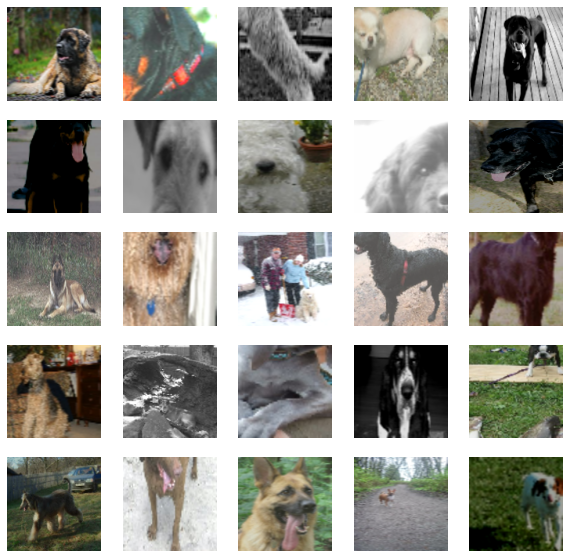

In [11]:
train_sample_one = next(iter(train_view_1))
visualize(train_sample_one)

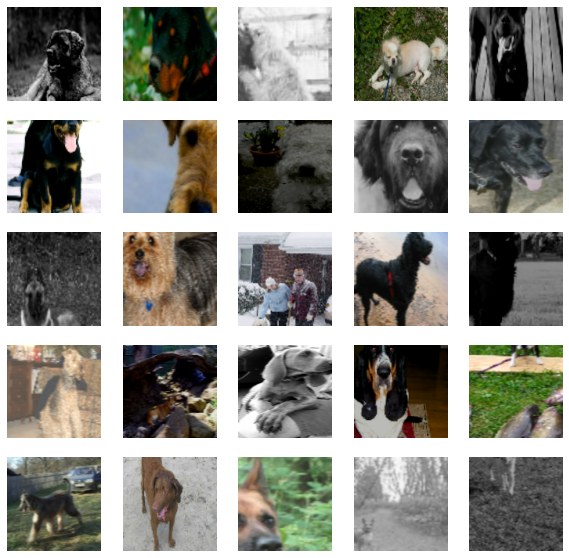

In [12]:
train_sample_two = next(iter(train_view_2))
visualize(train_sample_two)

This [example](https://keras.io/examples/vision/simsiam/) on the Keras website by Sayak Paul provides a tensorflow implementation of the Simsiam architecture from scratch - which is used in this notebook with some few modifications

In [13]:
class SimSiamLoss(tf.keras.losses.Loss):
    def __init__(self,name="loss",reduction=tf.keras.losses.Reduction.AUTO):
        super(SimSiamLoss,self).__init__(name=name,reduction=reduction)
    
    def call(self,projector,predictor):
        projector = tf.math.l2_normalize(projector,axis=1)
        predictor = tf.math.l2_normalize(predictor,axis=1)
        loss = tf.math.reduce_sum(projector * predictor,axis=1)
        return tf.constant([-1.0]) * loss
    
class MonitorStd(tf.keras.layers.Layer):
    def __init__(self,name):
        super(MonitorStd,self).__init__(name=name)
        
    def call(self,embedding):
        e = tf.math.l2_normalize(embedding,axis=-1)
        e = tf.math.reduce_std(e,axis=0)
        self.add_metric(e,name=self.name,aggregation="mean")
        return embedding

In [14]:
base = tf.keras.applications.resnet50.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = [*C.SHAPE,3],
)
base.trainable = False

def get_backbone():
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base(x,training=False)
    o = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="backbone")

def get_projector(dim):
    # backbone
    inputs = tf.keras.Input(shape=[dim,])
#     x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
#     x = base(x)
#     x = tf.keras.layers.GlobalAveragePooling2D(name='backbone_pool')(x)

    # projection mlp - formats representations into the right form for applying contrastive loss
    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                              use_bias = False,
#                               kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                              kernel_initializer = tf.keras.initializers.LecunUniform(),
                              )(x)
    x = tf.keras.layers.BatchNormalization(center=False,scale=False)(x)
    o = MonitorStd(name="proj_std")(x)

    return tf.keras.Model(inputs=inputs,outputs=o,name='projector')

def get_predictor():
    inputs = tf.keras.Input(shape=[C.PROJECTION_DIM,])
    x = tf.keras.layers.Dense(C.LATENT_DIM,
                       use_bias = False,
#                        kernel_regularizer = tf.keras.regularizers.L2(C.DECAY),
                        kernel_initializer = tf.keras.initializers.LecunUniform(),
                       )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.PROJECTION_DIM,
                        kernel_initializer = tf.keras.initializers.LecunUniform()
                             )(x)
    o = MonitorStd(name="pred_std")(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="predictor")


94781440/94765736 [==============================] - 3s 0us/step


In [15]:
# with strategy.scope():
#     base = tf.keras.applications.resnet_v2.ResNet50V2(
#     weights = "imagenet",
#     include_top = False,
#     input_shape = [*C.SHAPE,3],
# )
#     base.trainable = False
backbone = get_backbone()
backbone.summary()

Model: "backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 120, 120, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
dim = backbone.output.shape[-1]
# with strategy.scope():
projector = get_projector(dim)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4194304   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
re_lu (ReLU)                 (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2048)              0 

In [17]:
# with strategy.scope():
predictor = get_predictor()
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
pred_std (MonitorStd)        (None, 2048)              0         
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
___________________________________________

In [18]:
# with strategy.scope():
PRE_TRAIN_STEPS_PER_EPOCH = tf.data.experimental.cardinality(train).numpy() // C.GLOBAL_BATCH_SIZE
#     PRE_TEST_STEPS_PER_EPOCH = tf.data.experimental.cardinality(val) // C.GLOBAL_BATCH_SIZE
steps = C.EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH

lr_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.INIT_LR,
    decay_steps = steps
)

weight_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.DECAY,
    decay_steps = steps
)

optimizer = tfa.optimizers.SGDW(
    learning_rate = lr_decay,
    weight_decay = weight_decay,
    momentum = C.M
)
    
mcpt = tf.keras.callbacks.ModelCheckpoint(
    f"ckpts/loss_{date}",
    monitor = "loss",
    save_weights_only = True,
    verbose = 1
)

## uncomment when running on colab 
# tboard = tf.keras.callbacks.TensorBoard(
#     "simsiam/logs",
#     histogram_freq = 1,
#     update_freq = 10
# )

In [19]:
# plt.plot(range(steps),lr_decay(range(steps)))
# plt.xlabel("steps")
# plt.ylabel("learning rate")
# plt.title("Negative Loss Curve")

In [20]:
class SimSiam(tf.keras.Model):
    def __init__(self,backbone,projector,predictor):
        super(SimSiam,self).__init__()
        self.backbone = backbone
        self.projector = projector
        self.predictor = predictor
        
    
    @tf.function(jit_compile=True)
    def train_step(self,inputs):
        x1,x2 = inputs
        with tf.GradientTape() as tape:
            z1,z2,p1,p2,loss = self._forward_pass(x1,x2)
            reg_loss = sum(self.backbone.losses)
            reg_loss += sum(self.projector.losses)
            reg_loss += (sum(self.predictor.losses))
            total_loss = loss + reg_loss
        total_params = (
            self.backbone.trainable_variables +
            self.projector.trainable_variables +
            self.predictor.trainable_variables
        )
        grads = tape.gradient(total_loss,total_params)
        self.optimizer.apply_gradients(zip(grads,total_params))
        self.compiled_metrics.update_state([z1,z2],[p2,p1])
        return {m.name: m.result() for m in self.metrics}
    
    def _forward_pass(self,view1,view2):
        f1,f2 = self.backbone(view1), self.backbone(view2)
        z1,z2 = self.projector(f1), self.projector(f2)
        p1, p2 = self.predictor(z1), self.predictor(z2)

        l1 = self.compiled_loss(tf.stop_gradient(z1),p2)
        l2 = self.compiled_loss(tf.stop_gradient(z2),p1)
        loss = l1/2 + l2/2
        return z1,z2,p1,p2,loss

In [21]:
# with strategy.scope():
simsiam = SimSiam(backbone,projector,predictor)

simsiam.compile(
    optimizer = optimizer,
    loss = SimSiamLoss()
)

history = simsiam.fit(train_fused,
                  epochs=C.EPOCHS,
                  steps_per_epoch = PRE_TRAIN_STEPS_PER_EPOCH,
                  callbacks=[mcpt],
                  verbose=1)

Epoch 1/400


2023-01-29 09:52:30.077945: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f6798d35500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-29 09:52:30.078020: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-01-29 09:52:30.635317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-29 09:52:34.740696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/75 [..............................] - ETA: 28:44 - loss: -0.0064 - proj_std: 0.0131 - pred_std: 0.0122

2023-01-29 09:52:42.794630: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/75 [=========>....................] - ETA: 26s - loss: -0.5213 - proj_std: 0.0090 - pred_std: 0.0041

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.5718 - proj_std: 0.0086 - pred_std: 0.0037

Cleanup called...


75/75 [==============================] - 63s 531ms/step - loss: -0.8058 - proj_std: 0.0067 - pred_std: 0.0020

Epoch 00001: saving model to ckpts/loss_2023 01 29
Epoch 2/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9710 - proj_std: 0.0052 - pred_std: 6.9244e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9710 - proj_std: 0.0052 - pred_std: 6.9251e-04

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9718 - proj_std: 0.0051 - pred_std: 6.7521e-04

Epoch 00002: saving model to ckpts/loss_2023 01 29
Epoch 3/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9736 - proj_std: 0.0050 - pred_std: 6.3829e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9736 - proj_std: 0.0050 - pred_std: 6.3763e-04

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9742 - proj_std: 0.0049 - pred_std: 6.2376e-04

Epoch 00003: saving model to ckpts/loss_2023 01 29
Epoch 4/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9755 - proj_std: 0.0048 - pred_std: 5.9499e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9756 - proj_std: 0.0048 - pred_std: 5.9419e-04

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -0.9761 - proj_std: 0.0047 - pred_std: 5.8379e-04

Epoch 00004: saving model to ckpts/loss_2023 01 29
Epoch 5/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9772 - proj_std: 0.0046 - pred_std: 5.5963e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9773 - proj_std: 0.0046 - pred_std: 5.5942e-04

Cleanup called...


75/75 [==============================] - 43s 528ms/step - loss: -0.9777 - proj_std: 0.0046 - pred_std: 5.5078e-04

Epoch 00005: saving model to ckpts/loss_2023 01 29
Epoch 6/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9786 - proj_std: 0.0045 - pred_std: 5.3160e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9786 - proj_std: 0.0045 - pred_std: 5.3167e-04

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -0.9789 - proj_std: 0.0045 - pred_std: 5.2420e-04

Epoch 00006: saving model to ckpts/loss_2023 01 29
Epoch 7/400
30/75 [===========>..................] - ETA: 25s - loss: -0.9798 - proj_std: 0.0044 - pred_std: 5.0646e-04

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9801 - proj_std: 0.0043 - pred_std: 5.0108e-04

Epoch 00007: saving model to ckpts/loss_2023 01 29
Epoch 8/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9808 - proj_std: 0.0043 - pred_std: 4.8730e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9808 - proj_std: 0.0043 - pred_std: 4.8733e-04

Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -0.9811 - proj_std: 0.0042 - pred_std: 4.8268e-04

Epoch 00008: saving model to ckpts/loss_2023 01 29
Epoch 9/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9817 - proj_std: 0.0042 - pred_std: 4.7104e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9817 - proj_std: 0.0042 - pred_std: 4.7085e-04

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9819 - proj_std: 0.0041 - pred_std: 4.6721e-04

Epoch 00009: saving model to ckpts/loss_2023 01 29
Epoch 10/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9825 - proj_std: 0.0041 - pred_std: 4.5646e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9825 - proj_std: 0.0041 - pred_std: 4.5653e-04

Cleanup called...


75/75 [==============================] - 43s 527ms/step - loss: -0.9827 - proj_std: 0.0041 - pred_std: 4.5334e-04

Epoch 00010: saving model to ckpts/loss_2023 01 29
Epoch 11/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9832 - proj_std: 0.0040 - pred_std: 4.4585e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9832 - proj_std: 0.0040 - pred_std: 4.4578e-04

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9833 - proj_std: 0.0040 - pred_std: 4.4301e-04

Epoch 00011: saving model to ckpts/loss_2023 01 29
Epoch 12/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9839 - proj_std: 0.0039 - pred_std: 4.3492e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9839 - proj_std: 0.0039 - pred_std: 4.3473e-04

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9840 - proj_std: 0.0039 - pred_std: 4.3255e-04

Epoch 00012: saving model to ckpts/loss_2023 01 29
Epoch 13/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9843 - proj_std: 0.0039 - pred_std: 4.2879e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9843 - proj_std: 0.0039 - pred_std: 4.2825e-04

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -0.9845 - proj_std: 0.0039 - pred_std: 4.2551e-04

Epoch 00013: saving model to ckpts/loss_2023 01 29
Epoch 14/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9847 - proj_std: 0.0038 - pred_std: 4.2171e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9847 - proj_std: 0.0038 - pred_std: 4.2182e-04

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -0.9849 - proj_std: 0.0038 - pred_std: 4.1942e-04

Epoch 00014: saving model to ckpts/loss_2023 01 29
Epoch 15/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9853 - proj_std: 0.0038 - pred_std: 4.1537e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9853 - proj_std: 0.0038 - pred_std: 4.1554e-04

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9853 - proj_std: 0.0037 - pred_std: 4.1544e-04

Epoch 00015: saving model to ckpts/loss_2023 01 29
Epoch 16/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9856 - proj_std: 0.0037 - pred_std: 4.1346e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9856 - proj_std: 0.0037 - pred_std: 4.1376e-04

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -0.9857 - proj_std: 0.0037 - pred_std: 4.1358e-04

Epoch 00016: saving model to ckpts/loss_2023 01 29
Epoch 17/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9860 - proj_std: 0.0037 - pred_std: 4.1347e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9860 - proj_std: 0.0037 - pred_std: 4.1332e-04

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -0.9860 - proj_std: 0.0037 - pred_std: 4.1496e-04

Epoch 00017: saving model to ckpts/loss_2023 01 29
Epoch 18/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9861 - proj_std: 0.0037 - pred_std: 4.1989e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9861 - proj_std: 0.0037 - pred_std: 4.1970e-04

Cleanup called...


75/75 [==============================] - 43s 546ms/step - loss: -0.9862 - proj_std: 0.0036 - pred_std: 4.2173e-04

Epoch 00018: saving model to ckpts/loss_2023 01 29
Epoch 19/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9863 - proj_std: 0.0036 - pred_std: 4.2779e-04

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9863 - proj_std: 0.0036 - pred_std: 4.3114e-04

Epoch 00019: saving model to ckpts/loss_2023 01 29
Epoch 20/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.3872e-04

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -0.9864 - proj_std: 0.0036 - pred_std: 4.4512e-04

Epoch 00020: saving model to ckpts/loss_2023 01 29
Epoch 21/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.5609e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.5646e-04

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.5893e-04

Epoch 00021: saving model to ckpts/loss_2023 01 29
Epoch 22/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9866 - proj_std: 0.0036 - pred_std: 4.6592e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.6644e-04

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -0.9865 - proj_std: 0.0036 - pred_std: 4.7143e-04

Epoch 00022: saving model to ckpts/loss_2023 01 29
Epoch 23/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9864 - proj_std: 0.0036 - pred_std: 4.7711e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9864 - proj_std: 0.0036 - pred_std: 4.7750e-04

Cleanup called...


75/75 [==============================] - 43s 529ms/step - loss: -0.9863 - proj_std: 0.0036 - pred_std: 4.8166e-04

Epoch 00023: saving model to ckpts/loss_2023 01 29
Epoch 24/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9861 - proj_std: 0.0037 - pred_std: 4.9643e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9861 - proj_std: 0.0037 - pred_std: 4.9569e-04

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -0.9859 - proj_std: 0.0037 - pred_std: 5.0269e-04

Epoch 00024: saving model to ckpts/loss_2023 01 29
Epoch 25/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9856 - proj_std: 0.0037 - pred_std: 5.1456e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9857 - proj_std: 0.0037 - pred_std: 5.1374e-04

Cleanup called...


75/75 [==============================] - 43s 526ms/step - loss: -0.9854 - proj_std: 0.0038 - pred_std: 5.2541e-04

Epoch 00025: saving model to ckpts/loss_2023 01 29
Epoch 26/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9849 - proj_std: 0.0038 - pred_std: 5.5277e-04

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9847 - proj_std: 0.0039 - pred_std: 5.6678e-04

Epoch 00026: saving model to ckpts/loss_2023 01 29
Epoch 27/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9839 - proj_std: 0.0040 - pred_std: 6.0912e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9839 - proj_std: 0.0040 - pred_std: 6.1397e-04

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9834 - proj_std: 0.0040 - pred_std: 6.5489e-04

Epoch 00027: saving model to ckpts/loss_2023 01 29
Epoch 28/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9819 - proj_std: 0.0042 - pred_std: 7.9128e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9819 - proj_std: 0.0042 - pred_std: 7.9244e-04

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9808 - proj_std: 0.0044 - pred_std: 9.1426e-04

Epoch 00028: saving model to ckpts/loss_2023 01 29
Epoch 29/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9770 - proj_std: 0.0049 - pred_std: 0.0014

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9769 - proj_std: 0.0049 - pred_std: 0.0014

Cleanup called...


75/75 [==============================] - 43s 541ms/step - loss: -0.9724 - proj_std: 0.0055 - pred_std: 0.0020

Epoch 00029: saving model to ckpts/loss_2023 01 29
Epoch 30/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9685 - proj_std: 0.0062 - pred_std: 0.0032

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9701 - proj_std: 0.0060 - pred_std: 0.0033

Epoch 00030: saving model to ckpts/loss_2023 01 29
Epoch 31/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9787 - proj_std: 0.0051 - pred_std: 0.0030

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9787 - proj_std: 0.0051 - pred_std: 0.0030

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -0.9830 - proj_std: 0.0045 - pred_std: 0.0026

Epoch 00031: saving model to ckpts/loss_2023 01 29
Epoch 32/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9819 - proj_std: 0.0047 - pred_std: 0.0027

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9815 - proj_std: 0.0048 - pred_std: 0.0027

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9843 - proj_std: 0.0043 - pred_std: 0.0026

Epoch 00032: saving model to ckpts/loss_2023 01 29
Epoch 33/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9909 - proj_std: 0.0033 - pred_std: 0.0019

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9906 - proj_std: 0.0033 - pred_std: 0.0020

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9896 - proj_std: 0.0035 - pred_std: 0.0021

Epoch 00033: saving model to ckpts/loss_2023 01 29
Epoch 34/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9868 - proj_std: 0.0040 - pred_std: 0.0024

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9871 - proj_std: 0.0040 - pred_std: 0.0025

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9889 - proj_std: 0.0037 - pred_std: 0.0023

Epoch 00034: saving model to ckpts/loss_2023 01 29
Epoch 35/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9892 - proj_std: 0.0039 - pred_std: 0.0026

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9892 - proj_std: 0.0039 - pred_std: 0.0026

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9865 - proj_std: 0.0041 - pred_std: 0.0026

Epoch 00035: saving model to ckpts/loss_2023 01 29
Epoch 36/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9825 - proj_std: 0.0049 - pred_std: 0.0032

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9819 - proj_std: 0.0051 - pred_std: 0.0034

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9721 - proj_std: 0.0064 - pred_std: 0.0045

Epoch 00036: saving model to ckpts/loss_2023 01 29
Epoch 37/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9560 - proj_std: 0.0096 - pred_std: 0.0081

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9565 - proj_std: 0.0096 - pred_std: 0.0081

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9642 - proj_std: 0.0092 - pred_std: 0.0079

Epoch 00037: saving model to ckpts/loss_2023 01 29
Epoch 38/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9751 - proj_std: 0.0085 - pred_std: 0.0075

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9750 - proj_std: 0.0085 - pred_std: 0.0075

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -0.9770 - proj_std: 0.0082 - pred_std: 0.0072

Epoch 00038: saving model to ckpts/loss_2023 01 29
Epoch 39/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9782 - proj_std: 0.0080 - pred_std: 0.0072

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9785 - proj_std: 0.0080 - pred_std: 0.0071

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9791 - proj_std: 0.0079 - pred_std: 0.0070

Epoch 00039: saving model to ckpts/loss_2023 01 29
Epoch 40/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9805 - proj_std: 0.0079 - pred_std: 0.0070

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9802 - proj_std: 0.0078 - pred_std: 0.0070

Epoch 00040: saving model to ckpts/loss_2023 01 29
Epoch 41/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9758 - proj_std: 0.0084 - pred_std: 0.0073

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9754 - proj_std: 0.0084 - pred_std: 0.0073

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9787 - proj_std: 0.0082 - pred_std: 0.0073

Epoch 00041: saving model to ckpts/loss_2023 01 29
Epoch 42/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9807 - proj_std: 0.0078 - pred_std: 0.0070

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9804 - proj_std: 0.0078 - pred_std: 0.0069

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -0.9798 - proj_std: 0.0080 - pred_std: 0.0071

Epoch 00042: saving model to ckpts/loss_2023 01 29
Epoch 43/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9821 - proj_std: 0.0079 - pred_std: 0.0072

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9824 - proj_std: 0.0078 - pred_std: 0.0071

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9834 - proj_std: 0.0075 - pred_std: 0.0067

Epoch 00043: saving model to ckpts/loss_2023 01 29
Epoch 44/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9840 - proj_std: 0.0072 - pred_std: 0.0064

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9840 - proj_std: 0.0072 - pred_std: 0.0064

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9833 - proj_std: 0.0074 - pred_std: 0.0066

Epoch 00044: saving model to ckpts/loss_2023 01 29
Epoch 45/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9828 - proj_std: 0.0074 - pred_std: 0.0066

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9826 - proj_std: 0.0074 - pred_std: 0.0066

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9806 - proj_std: 0.0077 - pred_std: 0.0068

Epoch 00045: saving model to ckpts/loss_2023 01 29
Epoch 46/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9844 - proj_std: 0.0075 - pred_std: 0.0068

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9845 - proj_std: 0.0074 - pred_std: 0.0067

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9857 - proj_std: 0.0071 - pred_std: 0.0064

Epoch 00046: saving model to ckpts/loss_2023 01 29
Epoch 47/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9815 - proj_std: 0.0071 - pred_std: 0.0059

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9814 - proj_std: 0.0072 - pred_std: 0.0060

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -0.9797 - proj_std: 0.0078 - pred_std: 0.0068

Epoch 00047: saving model to ckpts/loss_2023 01 29
Epoch 48/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9811 - proj_std: 0.0079 - pred_std: 0.0071

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9817 - proj_std: 0.0078 - pred_std: 0.0070

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9838 - proj_std: 0.0073 - pred_std: 0.0066

Epoch 00048: saving model to ckpts/loss_2023 01 29
Epoch 49/400
30/75 [===========>..................] - ETA: 25s - loss: -0.9880 - proj_std: 0.0067 - pred_std: 0.0061

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -0.9866 - proj_std: 0.0065 - pred_std: 0.0057

Epoch 00049: saving model to ckpts/loss_2023 01 29
Epoch 50/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9821 - proj_std: 0.0077 - pred_std: 0.0068

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9820 - proj_std: 0.0076 - pred_std: 0.0067

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9836 - proj_std: 0.0074 - pred_std: 0.0066

Epoch 00050: saving model to ckpts/loss_2023 01 29
Epoch 51/400
27/75 [=========>....................] - ETA: 29s - loss: -0.9863 - proj_std: 0.0068 - pred_std: 0.0062

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -0.9861 - proj_std: 0.0068 - pred_std: 0.0062

Cleanup called...


75/75 [==============================] - 44s 548ms/step - loss: -0.9867 - proj_std: 0.0066 - pred_std: 0.0058

Epoch 00051: saving model to ckpts/loss_2023 01 29
Epoch 52/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9838 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9841 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9856 - proj_std: 0.0069 - pred_std: 0.0062

Epoch 00052: saving model to ckpts/loss_2023 01 29
Epoch 53/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9845 - proj_std: 0.0065 - pred_std: 0.0053

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9827 - proj_std: 0.0065 - pred_std: 0.0053

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9806 - proj_std: 0.0074 - pred_std: 0.0064

Epoch 00053: saving model to ckpts/loss_2023 01 29
Epoch 54/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9833 - proj_std: 0.0076 - pred_std: 0.0070

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9834 - proj_std: 0.0076 - pred_std: 0.0069

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9860 - proj_std: 0.0070 - pred_std: 0.0064

Epoch 00054: saving model to ckpts/loss_2023 01 29
Epoch 55/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9889 - proj_std: 0.0062 - pred_std: 0.0056

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9886 - proj_std: 0.0062 - pred_std: 0.0056

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9855 - proj_std: 0.0066 - pred_std: 0.0058

Epoch 00055: saving model to ckpts/loss_2023 01 29
Epoch 56/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9843 - proj_std: 0.0072 - pred_std: 0.0065

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9843 - proj_std: 0.0072 - pred_std: 0.0065

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9842 - proj_std: 0.0071 - pred_std: 0.0063

Epoch 00056: saving model to ckpts/loss_2023 01 29
Epoch 57/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9841 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9842 - proj_std: 0.0070 - pred_std: 0.0062

Cleanup called...


75/75 [==============================] - 44s 549ms/step - loss: -0.9855 - proj_std: 0.0068 - pred_std: 0.0061

Epoch 00057: saving model to ckpts/loss_2023 01 29
Epoch 58/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9827 - proj_std: 0.0068 - pred_std: 0.0058

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9828 - proj_std: 0.0068 - pred_std: 0.0058

Cleanup called...


75/75 [==============================] - 42s 521ms/step - loss: -0.9810 - proj_std: 0.0073 - pred_std: 0.0063

Epoch 00058: saving model to ckpts/loss_2023 01 29
Epoch 59/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9837 - proj_std: 0.0075 - pred_std: 0.0068

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9858 - proj_std: 0.0070 - pred_std: 0.0063

Epoch 00059: saving model to ckpts/loss_2023 01 29
Epoch 60/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9870 - proj_std: 0.0067 - pred_std: 0.0061

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9869 - proj_std: 0.0066 - pred_std: 0.0060

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9870 - proj_std: 0.0065 - pred_std: 0.0059

Epoch 00060: saving model to ckpts/loss_2023 01 29
Epoch 61/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9885 - proj_std: 0.0064 - pred_std: 0.0058

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -0.9830 - proj_std: 0.0067 - pred_std: 0.0056

Epoch 00061: saving model to ckpts/loss_2023 01 29
Epoch 62/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9777 - proj_std: 0.0086 - pred_std: 0.0078

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9780 - proj_std: 0.0086 - pred_std: 0.0078

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -0.9815 - proj_std: 0.0079 - pred_std: 0.0072

Epoch 00062: saving model to ckpts/loss_2023 01 29
Epoch 63/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9872 - proj_std: 0.0066 - pred_std: 0.0060

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9873 - proj_std: 0.0065 - pred_std: 0.0059

Cleanup called...


75/75 [==============================] - 44s 548ms/step - loss: -0.9891 - proj_std: 0.0061 - pred_std: 0.0056

Epoch 00063: saving model to ckpts/loss_2023 01 29
Epoch 64/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9904 - proj_std: 0.0056 - pred_std: 0.0050

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9905 - proj_std: 0.0056 - pred_std: 0.0050

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -0.9904 - proj_std: 0.0055 - pred_std: 0.0049

Epoch 00064: saving model to ckpts/loss_2023 01 29
Epoch 65/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9909 - proj_std: 0.0058 - pred_std: 0.0052

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9910 - proj_std: 0.0057 - pred_std: 0.0052

Cleanup called...


75/75 [==============================] - 44s 528ms/step - loss: -0.9909 - proj_std: 0.0055 - pred_std: 0.0049

Epoch 00065: saving model to ckpts/loss_2023 01 29
Epoch 66/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9843 - proj_std: 0.0063 - pred_std: 0.0052

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9843 - proj_std: 0.0064 - pred_std: 0.0053

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -0.9847 - proj_std: 0.0068 - pred_std: 0.0059

Epoch 00066: saving model to ckpts/loss_2023 01 29
Epoch 67/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9883 - proj_std: 0.0063 - pred_std: 0.0057

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9883 - proj_std: 0.0063 - pred_std: 0.0057

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -0.9892 - proj_std: 0.0060 - pred_std: 0.0054

Epoch 00067: saving model to ckpts/loss_2023 01 29
Epoch 68/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9870 - proj_std: 0.0059 - pred_std: 0.0050

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9858 - proj_std: 0.0059 - pred_std: 0.0048

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9799 - proj_std: 0.0071 - pred_std: 0.0059

Epoch 00068: saving model to ckpts/loss_2023 01 29
Epoch 69/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9829 - proj_std: 0.0076 - pred_std: 0.0068

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9831 - proj_std: 0.0075 - pred_std: 0.0068

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -0.9860 - proj_std: 0.0068 - pred_std: 0.0061

Epoch 00069: saving model to ckpts/loss_2023 01 29
Epoch 70/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9906 - proj_std: 0.0056 - pred_std: 0.0051

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9914 - proj_std: 0.0054 - pred_std: 0.0048

Epoch 00070: saving model to ckpts/loss_2023 01 29
Epoch 71/400
30/75 [===========>..................] - ETA: 25s - loss: -0.9925 - proj_std: 0.0049 - pred_std: 0.0044

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9912 - proj_std: 0.0050 - pred_std: 0.0044

Epoch 00071: saving model to ckpts/loss_2023 01 29
Epoch 72/400
26/75 [=========>....................] - ETA: 27s - loss: -0.9892 - proj_std: 0.0057 - pred_std: 0.0049

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9890 - proj_std: 0.0057 - pred_std: 0.0050

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9882 - proj_std: 0.0058 - pred_std: 0.0050

Epoch 00072: saving model to ckpts/loss_2023 01 29
Epoch 73/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9857 - proj_std: 0.0069 - pred_std: 0.0062

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9856 - proj_std: 0.0068 - pred_std: 0.0062

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -0.9877 - proj_std: 0.0063 - pred_std: 0.0056

Epoch 00073: saving model to ckpts/loss_2023 01 29
Epoch 74/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9891 - proj_std: 0.0058 - pred_std: 0.0051

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9892 - proj_std: 0.0057 - pred_std: 0.0051

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9885 - proj_std: 0.0059 - pred_std: 0.0052

Epoch 00074: saving model to ckpts/loss_2023 01 29
Epoch 75/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9895 - proj_std: 0.0059 - pred_std: 0.0053

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9894 - proj_std: 0.0059 - pred_std: 0.0053

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9899 - proj_std: 0.0056 - pred_std: 0.0050

Epoch 00075: saving model to ckpts/loss_2023 01 29
Epoch 76/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9869 - proj_std: 0.0062 - pred_std: 0.0054

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9872 - proj_std: 0.0062 - pred_std: 0.0054

Cleanup called...


75/75 [==============================] - 44s 552ms/step - loss: -0.9890 - proj_std: 0.0058 - pred_std: 0.0051

Epoch 00076: saving model to ckpts/loss_2023 01 29
Epoch 77/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9826 - proj_std: 0.0060 - pred_std: 0.0046

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9824 - proj_std: 0.0061 - pred_std: 0.0047

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -0.9794 - proj_std: 0.0073 - pred_std: 0.0063

Epoch 00077: saving model to ckpts/loss_2023 01 29
Epoch 78/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9849 - proj_std: 0.0070 - pred_std: 0.0063

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9852 - proj_std: 0.0070 - pred_std: 0.0063

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -0.9874 - proj_std: 0.0063 - pred_std: 0.0057

Epoch 00078: saving model to ckpts/loss_2023 01 29
Epoch 79/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9907 - proj_std: 0.0056 - pred_std: 0.0051

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9910 - proj_std: 0.0054 - pred_std: 0.0048

Epoch 00079: saving model to ckpts/loss_2023 01 29
Epoch 80/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9903 - proj_std: 0.0055 - pred_std: 0.0049

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9904 - proj_std: 0.0055 - pred_std: 0.0048

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -0.9883 - proj_std: 0.0058 - pred_std: 0.0051

Epoch 00080: saving model to ckpts/loss_2023 01 29
Epoch 81/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9833 - proj_std: 0.0072 - pred_std: 0.0063

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9836 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


75/75 [==============================] - 43s 541ms/step - loss: -0.9853 - proj_std: 0.0068 - pred_std: 0.0060

Epoch 00081: saving model to ckpts/loss_2023 01 29
Epoch 82/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9885 - proj_std: 0.0062 - pred_std: 0.0057

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9888 - proj_std: 0.0062 - pred_std: 0.0056

Cleanup called...


75/75 [==============================] - 45s 544ms/step - loss: -0.9897 - proj_std: 0.0058 - pred_std: 0.0052

Epoch 00082: saving model to ckpts/loss_2023 01 29
Epoch 83/400
30/75 [===========>..................] - ETA: 25s - loss: -0.9921 - proj_std: 0.0051 - pred_std: 0.0045

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -0.9920 - proj_std: 0.0050 - pred_std: 0.0044

Epoch 00083: saving model to ckpts/loss_2023 01 29
Epoch 84/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9832 - proj_std: 0.0067 - pred_std: 0.0056

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9832 - proj_std: 0.0068 - pred_std: 0.0057

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -0.9831 - proj_std: 0.0070 - pred_std: 0.0061

Epoch 00084: saving model to ckpts/loss_2023 01 29
Epoch 85/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9878 - proj_std: 0.0061 - pred_std: 0.0054

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9879 - proj_std: 0.0060 - pred_std: 0.0054

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -0.9890 - proj_std: 0.0058 - pred_std: 0.0051

Epoch 00085: saving model to ckpts/loss_2023 01 29
Epoch 86/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9849 - proj_std: 0.0068 - pred_std: 0.0059

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9863 - proj_std: 0.0066 - pred_std: 0.0059

Epoch 00086: saving model to ckpts/loss_2023 01 29
Epoch 87/400
30/75 [===========>..................] - ETA: 25s - loss: -0.9888 - proj_std: 0.0058 - pred_std: 0.0051

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9888 - proj_std: 0.0059 - pred_std: 0.0052

Epoch 00087: saving model to ckpts/loss_2023 01 29
Epoch 88/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9843 - proj_std: 0.0066 - pred_std: 0.0057

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9824 - proj_std: 0.0072 - pred_std: 0.0064

Epoch 00088: saving model to ckpts/loss_2023 01 29
Epoch 89/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9877 - proj_std: 0.0063 - pred_std: 0.0056

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9877 - proj_std: 0.0063 - pred_std: 0.0056

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9876 - proj_std: 0.0061 - pred_std: 0.0054

Epoch 00089: saving model to ckpts/loss_2023 01 29
Epoch 90/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9842 - proj_std: 0.0073 - pred_std: 0.0066

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9843 - proj_std: 0.0073 - pred_std: 0.0065

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9862 - proj_std: 0.0066 - pred_std: 0.0058

Epoch 00090: saving model to ckpts/loss_2023 01 29
Epoch 91/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9847 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9845 - proj_std: 0.0071 - pred_std: 0.0063

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9850 - proj_std: 0.0069 - pred_std: 0.0061

Epoch 00091: saving model to ckpts/loss_2023 01 29
Epoch 92/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9861 - proj_std: 0.0066 - pred_std: 0.0058

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9860 - proj_std: 0.0066 - pred_std: 0.0058

Cleanup called...


75/75 [==============================] - 44s 548ms/step - loss: -0.9821 - proj_std: 0.0072 - pred_std: 0.0063

Epoch 00092: saving model to ckpts/loss_2023 01 29
Epoch 93/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9792 - proj_std: 0.0081 - pred_std: 0.0071

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -0.9803 - proj_std: 0.0078 - pred_std: 0.0069

Epoch 00093: saving model to ckpts/loss_2023 01 29
Epoch 94/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9839 - proj_std: 0.0072 - pred_std: 0.0064

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9817 - proj_std: 0.0073 - pred_std: 0.0064

Epoch 00094: saving model to ckpts/loss_2023 01 29
Epoch 95/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9825 - proj_std: 0.0073 - pred_std: 0.0065

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -0.9807 - proj_std: 0.0075 - pred_std: 0.0066

Epoch 00095: saving model to ckpts/loss_2023 01 29
Epoch 96/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9786 - proj_std: 0.0081 - pred_std: 0.0072

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9789 - proj_std: 0.0080 - pred_std: 0.0071

Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -0.9813 - proj_std: 0.0072 - pred_std: 0.0064

Epoch 00096: saving model to ckpts/loss_2023 01 29
Epoch 97/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9790 - proj_std: 0.0080 - pred_std: 0.0070

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -0.9810 - proj_std: 0.0075 - pred_std: 0.0067

Epoch 00097: saving model to ckpts/loss_2023 01 29
Epoch 98/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9850 - proj_std: 0.0067 - pred_std: 0.0059

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9849 - proj_std: 0.0067 - pred_std: 0.0059

Cleanup called...


75/75 [==============================] - 43s 542ms/step - loss: -0.9826 - proj_std: 0.0069 - pred_std: 0.0060

Epoch 00098: saving model to ckpts/loss_2023 01 29
Epoch 99/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9774 - proj_std: 0.0081 - pred_std: 0.0071

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9772 - proj_std: 0.0081 - pred_std: 0.0071

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -0.9723 - proj_std: 0.0088 - pred_std: 0.0077

Epoch 00099: saving model to ckpts/loss_2023 01 29
Epoch 100/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9734 - proj_std: 0.0087 - pred_std: 0.0076

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9733 - proj_std: 0.0086 - pred_std: 0.0076

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9754 - proj_std: 0.0082 - pred_std: 0.0072

Epoch 00100: saving model to ckpts/loss_2023 01 29
Epoch 101/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9752 - proj_std: 0.0085 - pred_std: 0.0074

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9751 - proj_std: 0.0085 - pred_std: 0.0074

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -0.9701 - proj_std: 0.0092 - pred_std: 0.0081

Epoch 00101: saving model to ckpts/loss_2023 01 29
Epoch 102/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9778 - proj_std: 0.0081 - pred_std: 0.0072

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9780 - proj_std: 0.0080 - pred_std: 0.0071

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9787 - proj_std: 0.0075 - pred_std: 0.0066

Epoch 00102: saving model to ckpts/loss_2023 01 29
Epoch 103/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9711 - proj_std: 0.0082 - pred_std: 0.0071

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9701 - proj_std: 0.0083 - pred_std: 0.0072

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9655 - proj_std: 0.0090 - pred_std: 0.0078

Epoch 00103: saving model to ckpts/loss_2023 01 29
Epoch 104/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9645 - proj_std: 0.0094 - pred_std: 0.0083

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9639 - proj_std: 0.0095 - pred_std: 0.0083

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -0.9562 - proj_std: 0.0104 - pred_std: 0.0091

Epoch 00104: saving model to ckpts/loss_2023 01 29
Epoch 105/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9408 - proj_std: 0.0121 - pred_std: 0.0107

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 528ms/step - loss: -0.9440 - proj_std: 0.0121 - pred_std: 0.0109

Epoch 00105: saving model to ckpts/loss_2023 01 29
Epoch 106/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9499 - proj_std: 0.0121 - pred_std: 0.0111

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9497 - proj_std: 0.0122 - pred_std: 0.0112

Cleanup called...


75/75 [==============================] - 44s 530ms/step - loss: -0.9491 - proj_std: 0.0121 - pred_std: 0.0110

Epoch 00106: saving model to ckpts/loss_2023 01 29
Epoch 107/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9450 - proj_std: 0.0123 - pred_std: 0.0112

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9456 - proj_std: 0.0122 - pred_std: 0.0112

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -0.9528 - proj_std: 0.0116 - pred_std: 0.0106

Epoch 00107: saving model to ckpts/loss_2023 01 29
Epoch 108/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9606 - proj_std: 0.0109 - pred_std: 0.0099

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9603 - proj_std: 0.0109 - pred_std: 0.0099

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -0.9614 - proj_std: 0.0110 - pred_std: 0.0100

Epoch 00108: saving model to ckpts/loss_2023 01 29
Epoch 109/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9634 - proj_std: 0.0105 - pred_std: 0.0096

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9634 - proj_std: 0.0105 - pred_std: 0.0096

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9649 - proj_std: 0.0103 - pred_std: 0.0093

Epoch 00109: saving model to ckpts/loss_2023 01 29
Epoch 110/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9712 - proj_std: 0.0095 - pred_std: 0.0086

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9708 - proj_std: 0.0096 - pred_std: 0.0087

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9673 - proj_std: 0.0101 - pred_std: 0.0091

Epoch 00110: saving model to ckpts/loss_2023 01 29
Epoch 111/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9615 - proj_std: 0.0106 - pred_std: 0.0096

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9609 - proj_std: 0.0106 - pred_std: 0.0097

Cleanup called...


75/75 [==============================] - 43s 528ms/step - loss: -0.9621 - proj_std: 0.0106 - pred_std: 0.0096

Epoch 00111: saving model to ckpts/loss_2023 01 29
Epoch 112/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9636 - proj_std: 0.0105 - pred_std: 0.0095

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9639 - proj_std: 0.0105 - pred_std: 0.0095

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -0.9650 - proj_std: 0.0101 - pred_std: 0.0090

Epoch 00112: saving model to ckpts/loss_2023 01 29
Epoch 113/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9696 - proj_std: 0.0095 - pred_std: 0.0085

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9695 - proj_std: 0.0095 - pred_std: 0.0085

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9670 - proj_std: 0.0097 - pred_std: 0.0087

Epoch 00113: saving model to ckpts/loss_2023 01 29
Epoch 114/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9682 - proj_std: 0.0094 - pred_std: 0.0083

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -0.9703 - proj_std: 0.0093 - pred_std: 0.0083

Epoch 00114: saving model to ckpts/loss_2023 01 29
Epoch 115/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9730 - proj_std: 0.0087 - pred_std: 0.0076

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9733 - proj_std: 0.0087 - pred_std: 0.0077

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -0.9732 - proj_std: 0.0085 - pred_std: 0.0075

Epoch 00115: saving model to ckpts/loss_2023 01 29
Epoch 116/400
29/75 [==========>...................] - ETA: 26s - loss: -0.9704 - proj_std: 0.0088 - pred_std: 0.0077

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9704 - proj_std: 0.0088 - pred_std: 0.0077

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -0.9654 - proj_std: 0.0093 - pred_std: 0.0081

Epoch 00116: saving model to ckpts/loss_2023 01 29
Epoch 117/400
26/75 [=========>....................] - ETA: 27s - loss: -0.9655 - proj_std: 0.0091 - pred_std: 0.0080

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9654 - proj_std: 0.0091 - pred_std: 0.0080

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9671 - proj_std: 0.0092 - pred_std: 0.0081

Epoch 00117: saving model to ckpts/loss_2023 01 29
Epoch 118/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9695 - proj_std: 0.0092 - pred_std: 0.0082

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9692 - proj_std: 0.0092 - pred_std: 0.0082

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9620 - proj_std: 0.0095 - pred_std: 0.0083

Epoch 00118: saving model to ckpts/loss_2023 01 29
Epoch 119/400
28/75 [==========>...................] - ETA: 27s - loss: -0.9381 - proj_std: 0.0114 - pred_std: 0.0099

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9383 - proj_std: 0.0114 - pred_std: 0.0099

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -0.9433 - proj_std: 0.0111 - pred_std: 0.0097

Epoch 00119: saving model to ckpts/loss_2023 01 29
Epoch 120/400
28/75 [==========>...................] - ETA: 25s - loss: -0.9572 - proj_std: 0.0102 - pred_std: 0.0091

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9560 - proj_std: 0.0103 - pred_std: 0.0091

Cleanup called...


75/75 [==============================] - 43s 527ms/step - loss: -0.9522 - proj_std: 0.0106 - pred_std: 0.0093

Epoch 00120: saving model to ckpts/loss_2023 01 29
Epoch 121/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9555 - proj_std: 0.0100 - pred_std: 0.0087

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -0.9601 - proj_std: 0.0098 - pred_std: 0.0085

Epoch 00121: saving model to ckpts/loss_2023 01 29
Epoch 122/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9683 - proj_std: 0.0089 - pred_std: 0.0078

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9680 - proj_std: 0.0089 - pred_std: 0.0078

Cleanup called...


75/75 [==============================] - 42s 529ms/step - loss: -0.9680 - proj_std: 0.0088 - pred_std: 0.0077

Epoch 00122: saving model to ckpts/loss_2023 01 29
Epoch 123/400
29/75 [==========>...................] - ETA: 25s - loss: -0.9688 - proj_std: 0.0087 - pred_std: 0.0076

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9685 - proj_std: 0.0087 - pred_std: 0.0076

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -0.9696 - proj_std: 0.0085 - pred_std: 0.0073

Epoch 00123: saving model to ckpts/loss_2023 01 29
Epoch 124/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9629 - proj_std: 0.0093 - pred_std: 0.0080

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9633 - proj_std: 0.0093 - pred_std: 0.0080

Cleanup called...


75/75 [==============================] - 43s 528ms/step - loss: -0.9652 - proj_std: 0.0092 - pred_std: 0.0080

Epoch 00124: saving model to ckpts/loss_2023 01 29
Epoch 125/400
30/75 [===========>..................] - ETA: 24s - loss: -0.9627 - proj_std: 0.0094 - pred_std: 0.0082

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -0.9649 - proj_std: 0.0092 - pred_std: 0.0080

Epoch 00125: saving model to ckpts/loss_2023 01 29
Epoch 126/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9602 - proj_std: 0.0097 - pred_std: 0.0084

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9600 - proj_std: 0.0097 - pred_std: 0.0084

Cleanup called...


75/75 [==============================] - 45s 545ms/step - loss: -0.9611 - proj_std: 0.0096 - pred_std: 0.0083

Epoch 00126: saving model to ckpts/loss_2023 01 29
Epoch 127/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9568 - proj_std: 0.0096 - pred_std: 0.0081

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9563 - proj_std: 0.0097 - pred_std: 0.0082

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9561 - proj_std: 0.0099 - pred_std: 0.0084

Epoch 00127: saving model to ckpts/loss_2023 01 29
Epoch 128/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9325 - proj_std: 0.0121 - pred_std: 0.0104

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9360 - proj_std: 0.0117 - pred_std: 0.0101

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -0.9523 - proj_std: 0.0098 - pred_std: 0.0084

Epoch 00128: saving model to ckpts/loss_2023 01 29
Epoch 129/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9534 - proj_std: 0.0099 - pred_std: 0.0083

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9547 - proj_std: 0.0098 - pred_std: 0.0082

Cleanup called...


75/75 [==============================] - 43s 526ms/step - loss: -0.9575 - proj_std: 0.0093 - pred_std: 0.0078

Epoch 00129: saving model to ckpts/loss_2023 01 29
Epoch 130/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9488 - proj_std: 0.0101 - pred_std: 0.0084

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9483 - proj_std: 0.0101 - pred_std: 0.0084

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9458 - proj_std: 0.0103 - pred_std: 0.0087

Epoch 00130: saving model to ckpts/loss_2023 01 29
Epoch 131/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9624 - proj_std: 0.0076 - pred_std: 0.0057

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9628 - proj_std: 0.0075 - pred_std: 0.0056

Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -0.9640 - proj_std: 0.0077 - pred_std: 0.0060

Epoch 00131: saving model to ckpts/loss_2023 01 29
Epoch 132/400
27/75 [=========>....................] - ETA: 25s - loss: -0.9701 - proj_std: 0.0079 - pred_std: 0.0066

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9702 - proj_std: 0.0079 - pred_std: 0.0066

Cleanup called...


75/75 [==============================] - 42s 526ms/step - loss: -0.9710 - proj_std: 0.0079 - pred_std: 0.0066

Epoch 00132: saving model to ckpts/loss_2023 01 29
Epoch 133/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9761 - proj_std: 0.0073 - pred_std: 0.0063

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 531ms/step - loss: -0.9782 - proj_std: 0.0070 - pred_std: 0.0060

Epoch 00133: saving model to ckpts/loss_2023 01 29
Epoch 134/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9805 - proj_std: 0.0071 - pred_std: 0.0062

Cleanup called...
Cleanup called...


75/75 [==============================] - 42s 521ms/step - loss: -0.9814 - proj_std: 0.0066 - pred_std: 0.0056

Epoch 00134: saving model to ckpts/loss_2023 01 29
Epoch 135/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9844 - proj_std: 0.0059 - pred_std: 0.0050

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9850 - proj_std: 0.0058 - pred_std: 0.0050

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -0.9876 - proj_std: 0.0051 - pred_std: 0.0044

Epoch 00135: saving model to ckpts/loss_2023 01 29
Epoch 136/400
27/75 [=========>....................] - ETA: 25s - loss: -0.9905 - proj_std: 0.0044 - pred_std: 0.0037

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9906 - proj_std: 0.0044 - pred_std: 0.0037

Cleanup called...


75/75 [==============================] - 43s 528ms/step - loss: -0.9907 - proj_std: 0.0043 - pred_std: 0.0035

Epoch 00136: saving model to ckpts/loss_2023 01 29
Epoch 137/400
30/75 [===========>..................] - ETA: 23s - loss: -0.9930 - proj_std: 0.0038 - pred_std: 0.0033

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 534ms/step - loss: -0.9943 - proj_std: 0.0034 - pred_std: 0.0028

Epoch 00137: saving model to ckpts/loss_2023 01 29
Epoch 138/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9930 - proj_std: 0.0037 - pred_std: 0.0031

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9930 - proj_std: 0.0037 - pred_std: 0.0031

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -0.9939 - proj_std: 0.0035 - pred_std: 0.0029

Epoch 00138: saving model to ckpts/loss_2023 01 29
Epoch 139/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9944 - proj_std: 0.0033 - pred_std: 0.0027

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9946 - proj_std: 0.0033 - pred_std: 0.0027

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9944 - proj_std: 0.0033 - pred_std: 0.0027

Epoch 00139: saving model to ckpts/loss_2023 01 29
Epoch 140/400
27/75 [=========>....................] - ETA: 27s - loss: -0.9935 - proj_std: 0.0035 - pred_std: 0.0029

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9935 - proj_std: 0.0035 - pred_std: 0.0028

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -0.9941 - proj_std: 0.0033 - pred_std: 0.0027

Epoch 00140: saving model to ckpts/loss_2023 01 29
Epoch 141/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9962 - proj_std: 0.0027 - pred_std: 0.0021

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9961 - proj_std: 0.0026 - pred_std: 0.0021

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -0.9963 - proj_std: 0.0026 - pred_std: 0.0021

Epoch 00141: saving model to ckpts/loss_2023 01 29
Epoch 142/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9974 - proj_std: 0.0020 - pred_std: 0.0015

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9973 - proj_std: 0.0020 - pred_std: 0.0015

Cleanup called...


75/75 [==============================] - 44s 532ms/step - loss: -0.9971 - proj_std: 0.0022 - pred_std: 0.0017

Epoch 00142: saving model to ckpts/loss_2023 01 29
Epoch 143/400
29/75 [==========>...................] - ETA: 24s - loss: -0.9974 - proj_std: 0.0021 - pred_std: 0.0017

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9974 - proj_std: 0.0021 - pred_std: 0.0017

Cleanup called...


75/75 [==============================] - 42s 531ms/step - loss: -0.9975 - proj_std: 0.0020 - pred_std: 0.0017

Epoch 00143: saving model to ckpts/loss_2023 01 29
Epoch 144/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9985 - proj_std: 0.0016 - pred_std: 0.0012

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9984 - proj_std: 0.0016 - pred_std: 0.0012

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -0.9981 - proj_std: 0.0016 - pred_std: 0.0013

Epoch 00144: saving model to ckpts/loss_2023 01 29
Epoch 145/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9979 - proj_std: 0.0018 - pred_std: 0.0013

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -0.9978 - proj_std: 0.0018 - pred_std: 0.0014

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -0.9979 - proj_std: 0.0017 - pred_std: 0.0014

Epoch 00145: saving model to ckpts/loss_2023 01 29
Epoch 146/400
28/75 [==========>...................] - ETA: 26s - loss: -0.9982 - proj_std: 0.0015 - pred_std: 0.0012

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9982 - proj_std: 0.0015 - pred_std: 0.0012

Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -0.9983 - proj_std: 0.0014 - pred_std: 0.0011

Epoch 00146: saving model to ckpts/loss_2023 01 29
Epoch 147/400
27/75 [=========>....................] - ETA: 26s - loss: -0.9982 - proj_std: 0.0014 - pred_std: 8.5978e-04

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -0.9979 - proj_std: 0.0015 - pred_std: 9.3562e-04

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -0.9973 - proj_std: 0.0016 - pred_std: 0.0012

Epoch 00147: saving model to ckpts/loss_2023 01 29
Epoch 148/400
27/75 [=========>....................] - ETA: 28s - loss: -0.9999 - proj_std: 1.9728e-04 - pred_std: 1.4464e-04

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -0.9999 - proj_std: 1.9659e-04 - pred_std: 1.4326e-04

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -0.9999 - proj_std: 1.8142e-04 - pred_std: 1.2707e-04

Epoch 00148: saving model to ckpts/loss_2023 01 29
Epoch 149/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7216e-04 - pred_std: 1.1119e-04

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7101e-04 - pred_std: 1.1099e-04

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 1.6499e-04 - pred_std: 1.0290e-04

Epoch 00149: saving model to ckpts/loss_2023 01 29
Epoch 150/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.5898e-04 - pred_std: 9.3209e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.5952e-04 - pred_std: 9.3138e-05

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 1.5794e-04 - pred_std: 9.0363e-05

Epoch 00150: saving model to ckpts/loss_2023 01 29
Epoch 151/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 1.4945e-04 - pred_std: 8.0937e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.4875e-04 - pred_std: 8.0344e-05

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 1.4927e-04 - pred_std: 7.7836e-05

Epoch 00151: saving model to ckpts/loss_2023 01 29
Epoch 152/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.4282e-04 - pred_std: 7.1381e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.4161e-04 - pred_std: 7.0683e-05

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 1.4067e-04 - pred_std: 6.7593e-05

Epoch 00152: saving model to ckpts/loss_2023 01 29
Epoch 153/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.3764e-04 - pred_std: 6.2732e-05

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.3936e-04 - pred_std: 6.3790e-05

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 1.3647e-04 - pred_std: 5.9957e-05

Epoch 00153: saving model to ckpts/loss_2023 01 29
Epoch 154/400
28/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.3489e-04 - pred_std: 5.6579e-05

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.3548e-04 - pred_std: 5.6841e-05

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -1.0000 - proj_std: 1.3244e-04 - pred_std: 5.3246e-05

Epoch 00154: saving model to ckpts/loss_2023 01 29
Epoch 155/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.2644e-04 - pred_std: 4.7986e-05

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.2636e-04 - pred_std: 4.8028e-05

Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -1.0000 - proj_std: 1.2621e-04 - pred_std: 4.6409e-05

Epoch 00155: saving model to ckpts/loss_2023 01 29
Epoch 156/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.2444e-04 - pred_std: 4.3408e-05

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 1.2461e-04 - pred_std: 4.3505e-05

Cleanup called...


75/75 [==============================] - 43s 529ms/step - loss: -1.0000 - proj_std: 1.2228e-04 - pred_std: 4.1017e-05

Epoch 00156: saving model to ckpts/loss_2023 01 29
Epoch 157/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.1746e-04 - pred_std: 3.7520e-05

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.1923e-04 - pred_std: 3.7882e-05

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 1.1714e-04 - pred_std: 3.6305e-05

Epoch 00157: saving model to ckpts/loss_2023 01 29
Epoch 158/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.1442e-04 - pred_std: 3.3178e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.1512e-04 - pred_std: 3.3200e-05

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -1.0000 - proj_std: 1.1409e-04 - pred_std: 3.1994e-05

Epoch 00158: saving model to ckpts/loss_2023 01 29
Epoch 159/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.1347e-04 - pred_std: 2.9653e-05

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 536ms/step - loss: -1.0000 - proj_std: 1.1155e-04 - pred_std: 2.8331e-05

Epoch 00159: saving model to ckpts/loss_2023 01 29
Epoch 160/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.0882e-04 - pred_std: 2.6124e-05

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.0941e-04 - pred_std: 2.6175e-05

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 1.0843e-04 - pred_std: 2.5116e-05

Epoch 00160: saving model to ckpts/loss_2023 01 29
Epoch 161/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.0577e-04 - pred_std: 2.3083e-05

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 1.0471e-04 - pred_std: 2.1874e-05

Epoch 00161: saving model to ckpts/loss_2023 01 29
Epoch 162/400
28/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.0452e-04 - pred_std: 2.0877e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.0446e-04 - pred_std: 2.0864e-05

Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -1.0000 - proj_std: 1.0283e-04 - pred_std: 1.9535e-05

Epoch 00162: saving model to ckpts/loss_2023 01 29
Epoch 163/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 1.0073e-04 - pred_std: 1.7622e-05

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.0042e-04 - pred_std: 1.7610e-05

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -1.0000 - proj_std: 1.0027e-04 - pred_std: 1.6994e-05

Epoch 00163: saving model to ckpts/loss_2023 01 29
Epoch 164/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 9.7440e-05 - pred_std: 1.5274e-05

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 9.7372e-05 - pred_std: 1.5383e-05

Cleanup called...


75/75 [==============================] - 43s 529ms/step - loss: -1.0000 - proj_std: 9.7542e-05 - pred_std: 1.5028e-05

Epoch 00164: saving model to ckpts/loss_2023 01 29
Epoch 165/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 9.4095e-05 - pred_std: 1.3721e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 9.4096e-05 - pred_std: 1.3724e-05

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -1.0000 - proj_std: 9.3318e-05 - pred_std: 1.3077e-05

Epoch 00165: saving model to ckpts/loss_2023 01 29
Epoch 166/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 8.9880e-05 - pred_std: 1.1843e-05

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 9.0226e-05 - pred_std: 1.1927e-05

Cleanup called...


75/75 [==============================] - 43s 529ms/step - loss: -1.0000 - proj_std: 8.9317e-05 - pred_std: 1.1407e-05

Epoch 00166: saving model to ckpts/loss_2023 01 29
Epoch 167/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 8.5348e-05 - pred_std: 1.0435e-05

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -1.0000 - proj_std: 8.4121e-05 - pred_std: 9.9295e-06

Epoch 00167: saving model to ckpts/loss_2023 01 29
Epoch 168/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 8.1154e-05 - pred_std: 8.7837e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 8.1192e-05 - pred_std: 8.7855e-06

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -1.0000 - proj_std: 7.9819e-05 - pred_std: 8.3747e-06

Epoch 00168: saving model to ckpts/loss_2023 01 29
Epoch 169/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 7.6306e-05 - pred_std: 7.4445e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 7.6149e-05 - pred_std: 7.3899e-06

Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -1.0000 - proj_std: 7.5078e-05 - pred_std: 7.1109e-06

Epoch 00169: saving model to ckpts/loss_2023 01 29
Epoch 170/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 7.2673e-05 - pred_std: 6.6041e-06

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 7.2458e-05 - pred_std: 6.5859e-06

Cleanup called...


75/75 [==============================] - 43s 526ms/step - loss: -1.0000 - proj_std: 7.0722e-05 - pred_std: 6.1376e-06

Epoch 00170: saving model to ckpts/loss_2023 01 29
Epoch 171/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 6.7525e-05 - pred_std: 5.3635e-06

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 6.7590e-05 - pred_std: 5.3504e-06

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 6.6106e-05 - pred_std: 5.0865e-06

Epoch 00171: saving model to ckpts/loss_2023 01 29
Epoch 172/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 6.2907e-05 - pred_std: 4.5954e-06

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 6.2673e-05 - pred_std: 4.5943e-06

Cleanup called...


75/75 [==============================] - 43s 541ms/step - loss: -1.0000 - proj_std: 6.1361e-05 - pred_std: 4.4237e-06

Epoch 00172: saving model to ckpts/loss_2023 01 29
Epoch 173/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 5.9224e-05 - pred_std: 4.0494e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 5.9186e-05 - pred_std: 4.0315e-06

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -1.0000 - proj_std: 5.7167e-05 - pred_std: 3.7851e-06

Epoch 00173: saving model to ckpts/loss_2023 01 29
Epoch 174/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 5.4369e-05 - pred_std: 3.2967e-06

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.4546e-05 - pred_std: 3.3178e-06

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 5.3482e-05 - pred_std: 3.1460e-06

Epoch 00174: saving model to ckpts/loss_2023 01 29
Epoch 175/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 5.0450e-05 - pred_std: 2.7829e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 5.0491e-05 - pred_std: 2.7763e-06

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 4.9716e-05 - pred_std: 2.6925e-06

Epoch 00175: saving model to ckpts/loss_2023 01 29
Epoch 176/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 4.7337e-05 - pred_std: 2.4003e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.7258e-05 - pred_std: 2.3879e-06

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -1.0000 - proj_std: 4.6047e-05 - pred_std: 2.2636e-06

Epoch 00176: saving model to ckpts/loss_2023 01 29
Epoch 177/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.3903e-05 - pred_std: 2.0674e-06

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 4.2772e-05 - pred_std: 1.9307e-06

Epoch 00177: saving model to ckpts/loss_2023 01 29
Epoch 178/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 4.0732e-05 - pred_std: 1.7138e-06

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.0752e-05 - pred_std: 1.7226e-06

Cleanup called...


75/75 [==============================] - 44s 553ms/step - loss: -1.0000 - proj_std: 3.9891e-05 - pred_std: 1.6018e-06

Epoch 00178: saving model to ckpts/loss_2023 01 29
Epoch 179/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 3.7903e-05 - pred_std: 1.3983e-06

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.8290e-05 - pred_std: 1.4094e-06

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -1.0000 - proj_std: 3.7374e-05 - pred_std: 1.3501e-06

Epoch 00179: saving model to ckpts/loss_2023 01 29
Epoch 180/400
29/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 3.5654e-05 - pred_std: 1.2203e-06

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 3.4735e-05 - pred_std: 1.1555e-06

Epoch 00180: saving model to ckpts/loss_2023 01 29
Epoch 181/400
28/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 3.3077e-05 - pred_std: 1.0436e-06

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.3053e-05 - pred_std: 1.0398e-06

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 3.2240e-05 - pred_std: 9.7007e-07

Epoch 00181: saving model to ckpts/loss_2023 01 29
Epoch 182/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 3.1020e-05 - pred_std: 8.6142e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.0850e-05 - pred_std: 8.5329e-07

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 3.0200e-05 - pred_std: 8.1499e-07

Epoch 00182: saving model to ckpts/loss_2023 01 29
Epoch 183/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 2.9282e-05 - pred_std: 7.3170e-07

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.9072e-05 - pred_std: 7.2900e-07

Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -1.0000 - proj_std: 2.8528e-05 - pred_std: 6.9475e-07

Epoch 00183: saving model to ckpts/loss_2023 01 29
Epoch 184/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.7445e-05 - pred_std: 6.3391e-07

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 2.7469e-05 - pred_std: 6.3124e-07

Cleanup called...


75/75 [==============================] - 43s 541ms/step - loss: -1.0000 - proj_std: 2.6644e-05 - pred_std: 5.9251e-07

Epoch 00184: saving model to ckpts/loss_2023 01 29
Epoch 185/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 2.5656e-05 - pred_std: 5.3060e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.5588e-05 - pred_std: 5.2738e-07

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -1.0000 - proj_std: 2.5009e-05 - pred_std: 4.8450e-07

Epoch 00185: saving model to ckpts/loss_2023 01 29
Epoch 186/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.4162e-05 - pred_std: 4.0904e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.4025e-05 - pred_std: 4.0727e-07

Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -1.0000 - proj_std: 2.3754e-05 - pred_std: 3.9633e-07

Epoch 00186: saving model to ckpts/loss_2023 01 29
Epoch 187/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.2825e-05 - pred_std: 3.6443e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.2802e-05 - pred_std: 3.6373e-07

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 2.2360e-05 - pred_std: 3.4717e-07

Epoch 00187: saving model to ckpts/loss_2023 01 29
Epoch 188/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.1422e-05 - pred_std: 3.1464e-07

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.1390e-05 - pred_std: 3.1353e-07

Cleanup called...


75/75 [==============================] - 44s 532ms/step - loss: -1.0000 - proj_std: 2.1045e-05 - pred_std: 2.9745e-07

Epoch 00188: saving model to ckpts/loss_2023 01 29
Epoch 189/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 2.0171e-05 - pred_std: 2.7232e-07

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.0143e-05 - pred_std: 2.7242e-07

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -1.0000 - proj_std: 1.9736e-05 - pred_std: 2.5746e-07

Epoch 00189: saving model to ckpts/loss_2023 01 29
Epoch 190/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8824e-05 - pred_std: 2.3109e-07

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 549ms/step - loss: -1.0000 - proj_std: 1.8394e-05 - pred_std: 2.1865e-07

Epoch 00190: saving model to ckpts/loss_2023 01 29
Epoch 191/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8069e-05 - pred_std: 1.9752e-07

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7996e-05 - pred_std: 1.9745e-07

Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -1.0000 - proj_std: 1.7626e-05 - pred_std: 1.8839e-07

Epoch 00191: saving model to ckpts/loss_2023 01 29
Epoch 192/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7029e-05 - pred_std: 1.6834e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6995e-05 - pred_std: 1.6832e-07

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 1.6587e-05 - pred_std: 1.6045e-07

Epoch 00192: saving model to ckpts/loss_2023 01 29
Epoch 193/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 1.5874e-05 - pred_std: 1.4474e-07

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 1.5544e-05 - pred_std: 1.3871e-07

Epoch 00193: saving model to ckpts/loss_2023 01 29
Epoch 194/400
28/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 1.4977e-05 - pred_std: 1.2138e-07

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.5042e-05 - pred_std: 1.2158e-07

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 1.4732e-05 - pred_std: 1.1585e-07

Epoch 00194: saving model to ckpts/loss_2023 01 29
Epoch 195/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.4218e-05 - pred_std: 1.0524e-07

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.4209e-05 - pred_std: 1.0526e-07

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 1.3886e-05 - pred_std: 9.8675e-08

Epoch 00195: saving model to ckpts/loss_2023 01 29
Epoch 196/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.3330e-05 - pred_std: 8.9145e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.3267e-05 - pred_std: 8.9809e-08

Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -1.0000 - proj_std: 1.3020e-05 - pred_std: 8.6153e-08

Epoch 00196: saving model to ckpts/loss_2023 01 29
Epoch 197/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 1.2658e-05 - pred_std: 7.8630e-08

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.2735e-05 - pred_std: 7.9463e-08

Cleanup called...


75/75 [==============================] - 44s 533ms/step - loss: -1.0000 - proj_std: 1.2359e-05 - pred_std: 7.5551e-08

Epoch 00197: saving model to ckpts/loss_2023 01 29
Epoch 198/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.1795e-05 - pred_std: 6.4170e-08

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.1817e-05 - pred_std: 6.4124e-08

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -1.0000 - proj_std: 1.1641e-05 - pred_std: 6.0866e-08

Epoch 00198: saving model to ckpts/loss_2023 01 29
Epoch 199/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.1031e-05 - pred_std: 5.4672e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.1059e-05 - pred_std: 5.4704e-08

Cleanup called...


75/75 [==============================] - 44s 532ms/step - loss: -1.0000 - proj_std: 1.0902e-05 - pred_std: 5.2430e-08

Epoch 00199: saving model to ckpts/loss_2023 01 29
Epoch 200/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.0485e-05 - pred_std: 4.8591e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.0465e-05 - pred_std: 4.8532e-08

Cleanup called...


75/75 [==============================] - 44s 533ms/step - loss: -1.0000 - proj_std: 1.0310e-05 - pred_std: 4.6427e-08

Epoch 00200: saving model to ckpts/loss_2023 01 29
Epoch 201/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 9.9454e-06 - pred_std: 4.2890e-08

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 9.9549e-06 - pred_std: 4.2697e-08

Cleanup called...


75/75 [==============================] - 43s 530ms/step - loss: -1.0000 - proj_std: 9.8064e-06 - pred_std: 4.1279e-08

Epoch 00201: saving model to ckpts/loss_2023 01 29
Epoch 202/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 9.4215e-06 - pred_std: 3.8143e-08

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 9.3692e-06 - pred_std: 3.7962e-08

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 9.2477e-06 - pred_std: 3.5947e-08

Epoch 00202: saving model to ckpts/loss_2023 01 29
Epoch 203/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 8.8999e-06 - pred_std: 3.1998e-08

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 8.7916e-06 - pred_std: 3.1022e-08

Epoch 00203: saving model to ckpts/loss_2023 01 29
Epoch 204/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 8.4768e-06 - pred_std: 2.7888e-08

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 8.4705e-06 - pred_std: 2.7913e-08

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 8.3354e-06 - pred_std: 2.7093e-08

Epoch 00204: saving model to ckpts/loss_2023 01 29
Epoch 205/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 7.9847e-06 - pred_std: 2.3868e-08

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 7.9794e-06 - pred_std: 2.3897e-08

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 7.8848e-06 - pred_std: 2.3091e-08

Epoch 00205: saving model to ckpts/loss_2023 01 29
Epoch 206/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 7.5420e-06 - pred_std: 2.1193e-08

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 7.5409e-06 - pred_std: 2.1194e-08

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 7.4811e-06 - pred_std: 2.0249e-08

Epoch 00206: saving model to ckpts/loss_2023 01 29
Epoch 207/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 7.2442e-06 - pred_std: 1.8197e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 7.2079e-06 - pred_std: 1.8127e-08

Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -1.0000 - proj_std: 7.1149e-06 - pred_std: 1.7421e-08

Epoch 00207: saving model to ckpts/loss_2023 01 29
Epoch 208/400
29/75 [==========>...................] - ETA: 23s - loss: -1.0000 - proj_std: 6.8236e-06 - pred_std: 1.6043e-08

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 6.8078e-06 - pred_std: 1.5976e-08

Cleanup called...


75/75 [==============================] - 43s 529ms/step - loss: -1.0000 - proj_std: 6.6697e-06 - pred_std: 1.5324e-08

Epoch 00208: saving model to ckpts/loss_2023 01 29
Epoch 209/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 6.3592e-06 - pred_std: 1.4079e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 6.3527e-06 - pred_std: 1.4043e-08

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -1.0000 - proj_std: 6.2913e-06 - pred_std: 1.3543e-08

Epoch 00209: saving model to ckpts/loss_2023 01 29
Epoch 210/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 6.1916e-06 - pred_std: 1.2466e-08

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 6.1482e-06 - pred_std: 1.2313e-08

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 6.0398e-06 - pred_std: 1.1757e-08

Epoch 00210: saving model to ckpts/loss_2023 01 29
Epoch 211/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.8312e-06 - pred_std: 1.0746e-08

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 5.7355e-06 - pred_std: 1.0423e-08

Epoch 00211: saving model to ckpts/loss_2023 01 29
Epoch 212/400
29/75 [==========>...................] - ETA: 23s - loss: -0.9999 - proj_std: 5.5256e-06 - pred_std: 9.6569e-09

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 5.5552e-06 - pred_std: 9.6564e-09

Cleanup called...


75/75 [==============================] - 43s 527ms/step - loss: -1.0000 - proj_std: 5.4472e-06 - pred_std: 8.7914e-09

Epoch 00212: saving model to ckpts/loss_2023 01 29
Epoch 213/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.3223e-06 - pred_std: 7.5466e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 5.2175e-06 - pred_std: 7.3791e-09

Epoch 00213: saving model to ckpts/loss_2023 01 29
Epoch 214/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 4.9678e-06 - pred_std: 6.8891e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.9648e-06 - pred_std: 6.8158e-09

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 4.9036e-06 - pred_std: 6.5626e-09

Epoch 00214: saving model to ckpts/loss_2023 01 29
Epoch 215/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 4.8233e-06 - pred_std: 6.1799e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 4.8147e-06 - pred_std: 6.1613e-09

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 4.7247e-06 - pred_std: 5.9473e-09

Epoch 00215: saving model to ckpts/loss_2023 01 29
Epoch 216/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 4.5820e-06 - pred_std: 5.5359e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.5684e-06 - pred_std: 5.5420e-09

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 4.4759e-06 - pred_std: 5.3519e-09

Epoch 00216: saving model to ckpts/loss_2023 01 29
Epoch 217/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.3178e-06 - pred_std: 5.0098e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 544ms/step - loss: -1.0000 - proj_std: 4.2420e-06 - pred_std: 4.8214e-09

Epoch 00217: saving model to ckpts/loss_2023 01 29
Epoch 218/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 4.1611e-06 - pred_std: 4.5153e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 4.1545e-06 - pred_std: 4.5307e-09

Cleanup called...


75/75 [==============================] - 44s 534ms/step - loss: -1.0000 - proj_std: 4.0909e-06 - pred_std: 4.3830e-09

Epoch 00218: saving model to ckpts/loss_2023 01 29
Epoch 219/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 3.8614e-06 - pred_std: 4.0231e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 3.8775e-06 - pred_std: 4.0443e-09

Cleanup called...


75/75 [==============================] - 45s 545ms/step - loss: -1.0000 - proj_std: 3.8246e-06 - pred_std: 3.9703e-09

Epoch 00219: saving model to ckpts/loss_2023 01 29
Epoch 220/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.7842e-06 - pred_std: 3.7465e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.7737e-06 - pred_std: 3.7426e-09

Cleanup called...


75/75 [==============================] - 44s 533ms/step - loss: -1.0000 - proj_std: 3.6682e-06 - pred_std: 3.6091e-09

Epoch 00220: saving model to ckpts/loss_2023 01 29
Epoch 221/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.5663e-06 - pred_std: 3.3660e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.5793e-06 - pred_std: 3.3789e-09

Cleanup called...


75/75 [==============================] - 44s 534ms/step - loss: -1.0000 - proj_std: 3.5109e-06 - pred_std: 3.2807e-09

Epoch 00221: saving model to ckpts/loss_2023 01 29
Epoch 222/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.4311e-06 - pred_std: 3.1195e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.4417e-06 - pred_std: 3.1305e-09

Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 3.3563e-06 - pred_std: 2.9413e-09

Epoch 00222: saving model to ckpts/loss_2023 01 29
Epoch 223/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 3.2311e-06 - pred_std: 2.5985e-09

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 3.2322e-06 - pred_std: 2.6023e-09

Cleanup called...


75/75 [==============================] - 44s 552ms/step - loss: -1.0000 - proj_std: 3.1739e-06 - pred_std: 2.5258e-09

Epoch 00223: saving model to ckpts/loss_2023 01 29
Epoch 224/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.0767e-06 - pred_std: 2.3931e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.0894e-06 - pred_std: 2.4085e-09

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 3.0331e-06 - pred_std: 2.3447e-09

Epoch 00224: saving model to ckpts/loss_2023 01 29
Epoch 225/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.9661e-06 - pred_std: 2.2490e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 2.9073e-06 - pred_std: 2.1931e-09

Epoch 00225: saving model to ckpts/loss_2023 01 29
Epoch 226/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 2.8135e-06 - pred_std: 2.1047e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.8092e-06 - pred_std: 2.0995e-09

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -1.0000 - proj_std: 2.7833e-06 - pred_std: 2.0669e-09

Epoch 00226: saving model to ckpts/loss_2023 01 29
Epoch 227/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 2.7379e-06 - pred_std: 2.0045e-09

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 2.7265e-06 - pred_std: 1.9991e-09

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 2.6767e-06 - pred_std: 1.9494e-09

Epoch 00227: saving model to ckpts/loss_2023 01 29
Epoch 228/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.5680e-06 - pred_std: 1.8643e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.5703e-06 - pred_std: 1.8669e-09

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 2.5349e-06 - pred_std: 1.8305e-09

Epoch 00228: saving model to ckpts/loss_2023 01 29
Epoch 229/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.4341e-06 - pred_std: 1.7732e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -1.0000 - proj_std: 2.4253e-06 - pred_std: 1.7443e-09

Epoch 00229: saving model to ckpts/loss_2023 01 29
Epoch 230/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.3600e-06 - pred_std: 1.6784e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.3585e-06 - pred_std: 1.6766e-09

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 2.3220e-06 - pred_std: 1.6612e-09

Epoch 00230: saving model to ckpts/loss_2023 01 29
Epoch 231/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.2581e-06 - pred_std: 1.6057e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 2.2398e-06 - pred_std: 1.5897e-09

Epoch 00231: saving model to ckpts/loss_2023 01 29
Epoch 232/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 2.1571e-06 - pred_std: 1.5075e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 2.1605e-06 - pred_std: 1.5082e-09

Cleanup called...


75/75 [==============================] - 45s 563ms/step - loss: -1.0000 - proj_std: 2.1343e-06 - pred_std: 1.4817e-09

Epoch 00232: saving model to ckpts/loss_2023 01 29
Epoch 233/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 2.0539e-06 - pred_std: 1.4393e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -1.0000 - proj_std: 2.0430e-06 - pred_std: 1.4278e-09

Epoch 00233: saving model to ckpts/loss_2023 01 29
Epoch 234/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9807e-06 - pred_std: 1.4013e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.9864e-06 - pred_std: 1.4027e-09

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 1.9643e-06 - pred_std: 1.3911e-09

Epoch 00234: saving model to ckpts/loss_2023 01 29
Epoch 235/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.9153e-06 - pred_std: 1.3658e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9216e-06 - pred_std: 1.3625e-09

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 1.8842e-06 - pred_std: 1.3534e-09

Epoch 00235: saving model to ckpts/loss_2023 01 29
Epoch 236/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8457e-06 - pred_std: 1.3282e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8467e-06 - pred_std: 1.3277e-09

Cleanup called...


75/75 [==============================] - 44s 536ms/step - loss: -1.0000 - proj_std: 1.8190e-06 - pred_std: 1.3193e-09

Epoch 00236: saving model to ckpts/loss_2023 01 29
Epoch 237/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7517e-06 - pred_std: 1.3044e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7527e-06 - pred_std: 1.3070e-09

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 1.7412e-06 - pred_std: 1.2948e-09

Epoch 00237: saving model to ckpts/loss_2023 01 29
Epoch 238/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.6949e-06 - pred_std: 1.2847e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6934e-06 - pred_std: 1.2831e-09

Cleanup called...


75/75 [==============================] - 45s 545ms/step - loss: -1.0000 - proj_std: 1.6693e-06 - pred_std: 1.2704e-09

Epoch 00238: saving model to ckpts/loss_2023 01 29
Epoch 239/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 1.6369e-06 - pred_std: 1.2518e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -1.0000 - proj_std: 1.5950e-06 - pred_std: 1.2496e-09

Epoch 00239: saving model to ckpts/loss_2023 01 29
Epoch 240/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.5555e-06 - pred_std: 1.2352e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.5508e-06 - pred_std: 1.2333e-09

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.5400e-06 - pred_std: 1.2335e-09

Epoch 00240: saving model to ckpts/loss_2023 01 29
Epoch 241/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.5095e-06 - pred_std: 1.1987e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.5010e-06 - pred_std: 1.1944e-09

Cleanup called...


75/75 [==============================] - 44s 534ms/step - loss: -1.0000 - proj_std: 1.4781e-06 - pred_std: 1.1924e-09

Epoch 00241: saving model to ckpts/loss_2023 01 29
Epoch 242/400
29/75 [==========>...................] - ETA: 23s - loss: -1.0000 - proj_std: 1.4412e-06 - pred_std: 1.1965e-09

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 1.4452e-06 - pred_std: 1.1956e-09

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -1.0000 - proj_std: 1.4234e-06 - pred_std: 1.1802e-09

Epoch 00242: saving model to ckpts/loss_2023 01 29
Epoch 243/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.3968e-06 - pred_std: 1.1884e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.3923e-06 - pred_std: 1.1884e-09

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 1.3767e-06 - pred_std: 1.1755e-09

Epoch 00243: saving model to ckpts/loss_2023 01 29
Epoch 244/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 1.3366e-06 - pred_std: 1.1749e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.3390e-06 - pred_std: 1.1741e-09

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 1.3218e-06 - pred_std: 1.1681e-09

Epoch 00244: saving model to ckpts/loss_2023 01 29
Epoch 245/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.2920e-06 - pred_std: 1.1573e-09

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.2928e-06 - pred_std: 1.1566e-09

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 1.2732e-06 - pred_std: 1.1562e-09

Epoch 00245: saving model to ckpts/loss_2023 01 29
Epoch 246/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.2381e-06 - pred_std: 1.1437e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -1.0000 - proj_std: 1.2341e-06 - pred_std: 1.1486e-09

Epoch 00246: saving model to ckpts/loss_2023 01 29
Epoch 247/400
28/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 1.1990e-06 - pred_std: 1.1409e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.1984e-06 - pred_std: 1.1385e-09

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 1.1871e-06 - pred_std: 1.1383e-09

Epoch 00247: saving model to ckpts/loss_2023 01 29
Epoch 248/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.1550e-06 - pred_std: 1.1388e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.1514e-06 - pred_std: 1.1396e-09

Cleanup called...


75/75 [==============================] - 45s 546ms/step - loss: -1.0000 - proj_std: 1.1333e-06 - pred_std: 1.1240e-09

Epoch 00248: saving model to ckpts/loss_2023 01 29
Epoch 249/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.1216e-06 - pred_std: 1.1167e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.1214e-06 - pred_std: 1.1168e-09

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 1.1057e-06 - pred_std: 1.1158e-09

Epoch 00249: saving model to ckpts/loss_2023 01 29
Epoch 250/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.0804e-06 - pred_std: 1.1097e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 45s 558ms/step - loss: -1.0000 - proj_std: 1.0613e-06 - pred_std: 1.1035e-09

Epoch 00250: saving model to ckpts/loss_2023 01 29
Epoch 251/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.0501e-06 - pred_std: 1.1030e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.0476e-06 - pred_std: 1.1019e-09

Cleanup called...


75/75 [==============================] - 44s 531ms/step - loss: -1.0000 - proj_std: 1.0322e-06 - pred_std: 1.0943e-09

Epoch 00251: saving model to ckpts/loss_2023 01 29
Epoch 252/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.0140e-06 - pred_std: 1.0791e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.0066e-06 - pred_std: 1.0794e-09

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 9.9607e-07 - pred_std: 1.0756e-09

Epoch 00252: saving model to ckpts/loss_2023 01 29
Epoch 253/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 9.7004e-07 - pred_std: 1.0620e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 9.6957e-07 - pred_std: 1.0613e-09

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 9.5879e-07 - pred_std: 1.0678e-09

Epoch 00253: saving model to ckpts/loss_2023 01 29
Epoch 254/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 9.3198e-07 - pred_std: 1.0749e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 9.2698e-07 - pred_std: 1.0775e-09

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 9.2495e-07 - pred_std: 1.0714e-09

Epoch 00254: saving model to ckpts/loss_2023 01 29
Epoch 255/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 9.1072e-07 - pred_std: 1.0761e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 9.1756e-07 - pred_std: 1.0732e-09

Cleanup called...


75/75 [==============================] - 44s 536ms/step - loss: -1.0000 - proj_std: 8.9728e-07 - pred_std: 1.0602e-09

Epoch 00255: saving model to ckpts/loss_2023 01 29
Epoch 256/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 8.8271e-07 - pred_std: 1.0540e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 8.8921e-07 - pred_std: 1.0568e-09

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 8.6913e-07 - pred_std: 1.0582e-09

Epoch 00256: saving model to ckpts/loss_2023 01 29
Epoch 257/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 8.4722e-07 - pred_std: 1.0431e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -1.0000 - proj_std: 8.3521e-07 - pred_std: 1.0298e-09

Epoch 00257: saving model to ckpts/loss_2023 01 29
Epoch 258/400
29/75 [==========>...................] - ETA: 23s - loss: -1.0000 - proj_std: 8.1391e-07 - pred_std: 1.0141e-09

Cleanup called...


30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 8.1520e-07 - pred_std: 1.0163e-09

Cleanup called...


75/75 [==============================] - 44s 534ms/step - loss: -1.0000 - proj_std: 8.1089e-07 - pred_std: 1.0447e-09

Epoch 00258: saving model to ckpts/loss_2023 01 29
Epoch 259/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 7.9494e-07 - pred_std: 1.0794e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 7.9922e-07 - pred_std: 1.0820e-09

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 7.8527e-07 - pred_std: 1.0709e-09

Epoch 00259: saving model to ckpts/loss_2023 01 29
Epoch 260/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 7.8319e-07 - pred_std: 1.0697e-09

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 7.8081e-07 - pred_std: 1.0779e-09

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 7.6488e-07 - pred_std: 1.0729e-09

Epoch 00260: saving model to ckpts/loss_2023 01 29
Epoch 261/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 7.3895e-07 - pred_std: 1.0631e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 45s 548ms/step - loss: -1.0000 - proj_std: 7.3851e-07 - pred_std: 1.0465e-09

Epoch 00261: saving model to ckpts/loss_2023 01 29
Epoch 262/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 7.2665e-07 - pred_std: 1.0302e-09

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 7.1606e-07 - pred_std: 1.0323e-09

Epoch 00262: saving model to ckpts/loss_2023 01 29
Epoch 263/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 7.0699e-07 - pred_std: 1.0528e-09

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 7.0735e-07 - pred_std: 1.0505e-09

Cleanup called...


75/75 [==============================] - 43s 546ms/step - loss: -1.0000 - proj_std: 6.9649e-07 - pred_std: 1.0323e-09

Epoch 00263: saving model to ckpts/loss_2023 01 29
Epoch 264/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 6.8177e-07 - pred_std: 1.0293e-09

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 6.8499e-07 - pred_std: 1.0217e-09

Cleanup called...


75/75 [==============================] - 44s 532ms/step - loss: -1.0000 - proj_std: 6.8268e-07 - pred_std: 1.0128e-09

Epoch 00264: saving model to ckpts/loss_2023 01 29
Epoch 265/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 6.6979e-07 - pred_std: 9.9625e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 6.6173e-07 - pred_std: 9.8122e-10

Epoch 00265: saving model to ckpts/loss_2023 01 29
Epoch 266/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 6.4488e-07 - pred_std: 9.4837e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 6.4810e-07 - pred_std: 9.5267e-10

Cleanup called...


75/75 [==============================] - 43s 534ms/step - loss: -1.0000 - proj_std: 6.4085e-07 - pred_std: 9.6871e-10

Epoch 00266: saving model to ckpts/loss_2023 01 29
Epoch 267/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 6.3013e-07 - pred_std: 9.6412e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 6.3023e-07 - pred_std: 9.6843e-10

Cleanup called...


75/75 [==============================] - 45s 551ms/step - loss: -1.0000 - proj_std: 6.1941e-07 - pred_std: 9.4741e-10

Epoch 00267: saving model to ckpts/loss_2023 01 29
Epoch 268/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 6.0936e-07 - pred_std: 9.3728e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 6.0286e-07 - pred_std: 9.2526e-10

Epoch 00268: saving model to ckpts/loss_2023 01 29
Epoch 269/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 6.0203e-07 - pred_std: 9.0587e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 551ms/step - loss: -1.0000 - proj_std: 5.8820e-07 - pred_std: 9.0719e-10

Epoch 00269: saving model to ckpts/loss_2023 01 29
Epoch 270/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 5.7452e-07 - pred_std: 8.9647e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.7535e-07 - pred_std: 8.9436e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 5.6824e-07 - pred_std: 8.7395e-10

Epoch 00270: saving model to ckpts/loss_2023 01 29
Epoch 271/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 5.5724e-07 - pred_std: 8.9600e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 5.6052e-07 - pred_std: 8.9224e-10

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 5.5327e-07 - pred_std: 8.7401e-10

Epoch 00271: saving model to ckpts/loss_2023 01 29
Epoch 272/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 5.5439e-07 - pred_std: 8.5248e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.5245e-07 - pred_std: 8.4914e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 5.3949e-07 - pred_std: 8.3285e-10

Epoch 00272: saving model to ckpts/loss_2023 01 29
Epoch 273/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 5.2831e-07 - pred_std: 8.9269e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 5.2894e-07 - pred_std: 8.7152e-10

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 5.2729e-07 - pred_std: 8.3779e-10

Epoch 00273: saving model to ckpts/loss_2023 01 29
Epoch 274/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 5.1814e-07 - pred_std: 8.5992e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 5.1336e-07 - pred_std: 8.8266e-10

Cleanup called...


75/75 [==============================] - 43s 532ms/step - loss: -1.0000 - proj_std: 5.1299e-07 - pred_std: 8.0666e-10

Epoch 00274: saving model to ckpts/loss_2023 01 29
Epoch 275/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 5.0861e-07 - pred_std: 8.1198e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 5.0894e-07 - pred_std: 8.1503e-10

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 5.0378e-07 - pred_std: 7.7169e-10

Epoch 00275: saving model to ckpts/loss_2023 01 29
Epoch 276/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 4.9268e-07 - pred_std: 7.6384e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 4.9261e-07 - pred_std: 7.4379e-10

Cleanup called...


75/75 [==============================] - 44s 533ms/step - loss: -1.0000 - proj_std: 4.8715e-07 - pred_std: 7.2052e-10

Epoch 00276: saving model to ckpts/loss_2023 01 29
Epoch 277/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 4.6960e-07 - pred_std: 7.2839e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 4.7332e-07 - pred_std: 7.1671e-10

Epoch 00277: saving model to ckpts/loss_2023 01 29
Epoch 278/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 4.7060e-07 - pred_std: 7.2290e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 4.6764e-07 - pred_std: 6.9197e-10

Cleanup called...


75/75 [==============================] - 45s 539ms/step - loss: -1.0000 - proj_std: 4.6773e-07 - pred_std: 6.9264e-10

Epoch 00278: saving model to ckpts/loss_2023 01 29
Epoch 279/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 4.5810e-07 - pred_std: 6.6005e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 4.5461e-07 - pred_std: 6.3333e-10

Epoch 00279: saving model to ckpts/loss_2023 01 29
Epoch 280/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 4.5732e-07 - pred_std: 6.5655e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 550ms/step - loss: -1.0000 - proj_std: 4.4861e-07 - pred_std: 6.5898e-10

Epoch 00280: saving model to ckpts/loss_2023 01 29
Epoch 281/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 4.3771e-07 - pred_std: 5.9816e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 4.3983e-07 - pred_std: 5.8796e-10

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 4.3393e-07 - pred_std: 6.2286e-10

Epoch 00281: saving model to ckpts/loss_2023 01 29
Epoch 282/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 4.2200e-07 - pred_std: 5.6511e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.2364e-07 - pred_std: 5.8470e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 4.2334e-07 - pred_std: 5.9311e-10

Epoch 00282: saving model to ckpts/loss_2023 01 29
Epoch 283/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 4.1530e-07 - pred_std: 5.6327e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 4.1628e-07 - pred_std: 5.4837e-10

Cleanup called...


75/75 [==============================] - 45s 553ms/step - loss: -1.0000 - proj_std: 4.1677e-07 - pred_std: 5.5115e-10

Epoch 00283: saving model to ckpts/loss_2023 01 29
Epoch 284/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 4.0409e-07 - pred_std: 5.1060e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 4.0678e-07 - pred_std: 5.1832e-10

Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -1.0000 - proj_std: 4.0429e-07 - pred_std: 5.0591e-10

Epoch 00284: saving model to ckpts/loss_2023 01 29
Epoch 285/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 3.9361e-07 - pred_std: 4.8137e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.9456e-07 - pred_std: 4.8085e-10

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 3.9355e-07 - pred_std: 4.8887e-10

Epoch 00285: saving model to ckpts/loss_2023 01 29
Epoch 286/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.9489e-07 - pred_std: 5.7287e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 3.8970e-07 - pred_std: 5.1894e-10

Epoch 00286: saving model to ckpts/loss_2023 01 29
Epoch 287/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.8329e-07 - pred_std: 5.7178e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 3.7896e-07 - pred_std: 4.5257e-10

Epoch 00287: saving model to ckpts/loss_2023 01 29
Epoch 288/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.7142e-07 - pred_std: 4.6297e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.7042e-07 - pred_std: 4.6949e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 3.7424e-07 - pred_std: 4.7359e-10

Epoch 00288: saving model to ckpts/loss_2023 01 29
Epoch 289/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 3.7145e-07 - pred_std: 4.9799e-10

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 3.7130e-07 - pred_std: 4.9728e-10

Cleanup called...


75/75 [==============================] - 44s 552ms/step - loss: -1.0000 - proj_std: 3.6567e-07 - pred_std: 4.5050e-10

Epoch 00289: saving model to ckpts/loss_2023 01 29
Epoch 290/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.5909e-07 - pred_std: 3.6856e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.5757e-07 - pred_std: 3.9035e-10

Cleanup called...


75/75 [==============================] - 44s 536ms/step - loss: -1.0000 - proj_std: 3.5478e-07 - pred_std: 4.0506e-10

Epoch 00290: saving model to ckpts/loss_2023 01 29
Epoch 291/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 3.5468e-07 - pred_std: 4.7658e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.5409e-07 - pred_std: 4.9262e-10

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 3.5248e-07 - pred_std: 4.4478e-10

Epoch 00291: saving model to ckpts/loss_2023 01 29
Epoch 292/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 3.4710e-07 - pred_std: 4.0390e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.4759e-07 - pred_std: 3.9652e-10

Cleanup called...


75/75 [==============================] - 44s 533ms/step - loss: -1.0000 - proj_std: 3.4413e-07 - pred_std: 3.6048e-10

Epoch 00292: saving model to ckpts/loss_2023 01 29
Epoch 293/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 3.3790e-07 - pred_std: 4.2560e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.3777e-07 - pred_std: 4.1134e-10

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 3.3700e-07 - pred_std: 3.9666e-10

Epoch 00293: saving model to ckpts/loss_2023 01 29
Epoch 294/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 3.3461e-07 - pred_std: 3.2191e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 3.3454e-07 - pred_std: 3.2217e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 3.3083e-07 - pred_std: 3.8712e-10

Epoch 00294: saving model to ckpts/loss_2023 01 29
Epoch 295/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 3.3124e-07 - pred_std: 3.0327e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.2970e-07 - pred_std: 3.0575e-10

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 3.2545e-07 - pred_std: 3.3467e-10

Epoch 00295: saving model to ckpts/loss_2023 01 29
Epoch 296/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 3.2186e-07 - pred_std: 2.6524e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.2102e-07 - pred_std: 2.8262e-10

Cleanup called...


75/75 [==============================] - 43s 533ms/step - loss: -1.0000 - proj_std: 3.1948e-07 - pred_std: 3.3932e-10

Epoch 00296: saving model to ckpts/loss_2023 01 29
Epoch 297/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 3.1533e-07 - pred_std: 2.9256e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 3.1570e-07 - pred_std: 2.8898e-10

Cleanup called...


75/75 [==============================] - 45s 543ms/step - loss: -1.0000 - proj_std: 3.1248e-07 - pred_std: 2.8509e-10

Epoch 00297: saving model to ckpts/loss_2023 01 29
Epoch 298/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 3.1439e-07 - pred_std: 2.8861e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 3.1260e-07 - pred_std: 2.8156e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 3.0941e-07 - pred_std: 2.7850e-10

Epoch 00298: saving model to ckpts/loss_2023 01 29
Epoch 299/400
29/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 3.0335e-07 - pred_std: 3.4645e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 3.0260e-07 - pred_std: 3.3907e-10

Cleanup called...


75/75 [==============================] - 43s 541ms/step - loss: -1.0000 - proj_std: 3.0037e-07 - pred_std: 2.9206e-10

Epoch 00299: saving model to ckpts/loss_2023 01 29
Epoch 300/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.9727e-07 - pred_std: 3.6163e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.9606e-07 - pred_std: 3.5840e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 2.9534e-07 - pred_std: 2.7568e-10

Epoch 00300: saving model to ckpts/loss_2023 01 29
Epoch 301/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.9619e-07 - pred_std: 3.0623e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.9585e-07 - pred_std: 2.9245e-10

Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 2.9425e-07 - pred_std: 2.8843e-10

Epoch 00301: saving model to ckpts/loss_2023 01 29
Epoch 302/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.9139e-07 - pred_std: 2.7456e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 549ms/step - loss: -1.0000 - proj_std: 2.8791e-07 - pred_std: 2.8889e-10

Epoch 00302: saving model to ckpts/loss_2023 01 29
Epoch 303/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.8425e-07 - pred_std: 3.2623e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.8438e-07 - pred_std: 3.1078e-10

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 2.8263e-07 - pred_std: 2.9281e-10

Epoch 00303: saving model to ckpts/loss_2023 01 29
Epoch 304/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 2.8347e-07 - pred_std: 3.0585e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.8400e-07 - pred_std: 2.9560e-10

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -1.0000 - proj_std: 2.8123e-07 - pred_std: 3.0796e-10

Epoch 00304: saving model to ckpts/loss_2023 01 29
Epoch 305/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 2.7805e-07 - pred_std: 2.4191e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.7871e-07 - pred_std: 2.4820e-10

Cleanup called...


75/75 [==============================] - 44s 549ms/step - loss: -1.0000 - proj_std: 2.7409e-07 - pred_std: 2.3395e-10

Epoch 00305: saving model to ckpts/loss_2023 01 29
Epoch 306/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.7551e-07 - pred_std: 2.5912e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.7558e-07 - pred_std: 2.4803e-10

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 2.7236e-07 - pred_std: 2.1900e-10

Epoch 00306: saving model to ckpts/loss_2023 01 29
Epoch 307/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 2.7206e-07 - pred_std: 2.6034e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 2.6687e-07 - pred_std: 2.2153e-10

Epoch 00307: saving model to ckpts/loss_2023 01 29
Epoch 308/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.6507e-07 - pred_std: 1.8967e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.6605e-07 - pred_std: 1.9797e-10

Cleanup called...


75/75 [==============================] - 46s 543ms/step - loss: -1.0000 - proj_std: 2.6283e-07 - pred_std: 2.4288e-10

Epoch 00308: saving model to ckpts/loss_2023 01 29
Epoch 309/400
29/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 2.6445e-07 - pred_std: 2.0838e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 2.6009e-07 - pred_std: 2.3609e-10

Epoch 00309: saving model to ckpts/loss_2023 01 29
Epoch 310/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 2.5877e-07 - pred_std: 1.9689e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.5827e-07 - pred_std: 2.0038e-10

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 2.5791e-07 - pred_std: 2.0990e-10

Epoch 00310: saving model to ckpts/loss_2023 01 29
Epoch 311/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 2.5223e-07 - pred_std: 1.8425e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.5123e-07 - pred_std: 1.8209e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 2.5090e-07 - pred_std: 2.4854e-10

Epoch 00311: saving model to ckpts/loss_2023 01 29
Epoch 312/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.4763e-07 - pred_std: 1.4141e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.4816e-07 - pred_std: 1.3981e-10

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 2.4873e-07 - pred_std: 1.7005e-10

Epoch 00312: saving model to ckpts/loss_2023 01 29
Epoch 313/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.4543e-07 - pred_std: 1.9126e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.4512e-07 - pred_std: 1.8361e-10

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 2.4638e-07 - pred_std: 1.6667e-10

Epoch 00313: saving model to ckpts/loss_2023 01 29
Epoch 314/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.4286e-07 - pred_std: 2.2230e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.4376e-07 - pred_std: 2.3719e-10

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 2.4086e-07 - pred_std: 2.1223e-10

Epoch 00314: saving model to ckpts/loss_2023 01 29
Epoch 315/400
29/75 [==========>...................] - ETA: 23s - loss: -1.0000 - proj_std: 2.4294e-07 - pred_std: 2.5702e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 2.4063e-07 - pred_std: 2.2050e-10

Epoch 00315: saving model to ckpts/loss_2023 01 29
Epoch 316/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.3688e-07 - pred_std: 1.8268e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.3812e-07 - pred_std: 1.7422e-10

Cleanup called...


75/75 [==============================] - 45s 543ms/step - loss: -1.0000 - proj_std: 2.3611e-07 - pred_std: 1.8318e-10

Epoch 00316: saving model to ckpts/loss_2023 01 29
Epoch 317/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.3251e-07 - pred_std: 1.8431e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.3370e-07 - pred_std: 1.7624e-10

Cleanup called...


75/75 [==============================] - 44s 535ms/step - loss: -1.0000 - proj_std: 2.3409e-07 - pred_std: 1.5895e-10

Epoch 00317: saving model to ckpts/loss_2023 01 29
Epoch 318/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.3606e-07 - pred_std: 1.4631e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.3618e-07 - pred_std: 1.4141e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 2.3295e-07 - pred_std: 1.5210e-10

Epoch 00318: saving model to ckpts/loss_2023 01 29
Epoch 319/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.3001e-07 - pred_std: 1.4823e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 535ms/step - loss: -1.0000 - proj_std: 2.3003e-07 - pred_std: 1.9926e-10

Epoch 00319: saving model to ckpts/loss_2023 01 29
Epoch 320/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.3070e-07 - pred_std: 1.8784e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.3058e-07 - pred_std: 1.7714e-10

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 2.2778e-07 - pred_std: 1.8165e-10

Epoch 00320: saving model to ckpts/loss_2023 01 29
Epoch 321/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.2309e-07 - pred_std: 1.5466e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.2348e-07 - pred_std: 1.4813e-10

Cleanup called...


75/75 [==============================] - 45s 555ms/step - loss: -1.0000 - proj_std: 2.2302e-07 - pred_std: 1.3608e-10

Epoch 00321: saving model to ckpts/loss_2023 01 29
Epoch 322/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.1975e-07 - pred_std: 1.4483e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.1923e-07 - pred_std: 1.6489e-10

Cleanup called...


75/75 [==============================] - 45s 537ms/step - loss: -1.0000 - proj_std: 2.2104e-07 - pred_std: 1.8229e-10

Epoch 00322: saving model to ckpts/loss_2023 01 29
Epoch 323/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.2130e-07 - pred_std: 1.5708e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -1.0000 - proj_std: 2.1839e-07 - pred_std: 1.6458e-10

Epoch 00323: saving model to ckpts/loss_2023 01 29
Epoch 324/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 2.1736e-07 - pred_std: 1.5652e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.1817e-07 - pred_std: 1.7821e-10

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 2.1718e-07 - pred_std: 1.8879e-10

Epoch 00324: saving model to ckpts/loss_2023 01 29
Epoch 325/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.1717e-07 - pred_std: 1.0965e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.1608e-07 - pred_std: 1.1216e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 2.1542e-07 - pred_std: 1.2471e-10

Epoch 00325: saving model to ckpts/loss_2023 01 29
Epoch 326/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.1458e-07 - pred_std: 1.0536e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.1507e-07 - pred_std: 1.0355e-10

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 2.1440e-07 - pred_std: 1.0042e-10

Epoch 00326: saving model to ckpts/loss_2023 01 29
Epoch 327/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.1275e-07 - pred_std: 8.3759e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.1146e-07 - pred_std: 8.2343e-11

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -1.0000 - proj_std: 2.1057e-07 - pred_std: 1.2954e-10

Epoch 00327: saving model to ckpts/loss_2023 01 29
Epoch 328/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 2.0887e-07 - pred_std: 1.1731e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.1033e-07 - pred_std: 1.1519e-10

Cleanup called...


75/75 [==============================] - 45s 546ms/step - loss: -1.0000 - proj_std: 2.0948e-07 - pred_std: 1.2631e-10

Epoch 00328: saving model to ckpts/loss_2023 01 29
Epoch 329/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.0743e-07 - pred_std: 1.6703e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.0902e-07 - pred_std: 1.8198e-10

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -1.0000 - proj_std: 2.0802e-07 - pred_std: 1.6441e-10

Epoch 00329: saving model to ckpts/loss_2023 01 29
Epoch 330/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 2.0351e-07 - pred_std: 1.5239e-10

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 2.0485e-07 - pred_std: 1.5732e-10

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 2.0496e-07 - pred_std: 1.5575e-10

Epoch 00330: saving model to ckpts/loss_2023 01 29
Epoch 331/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 2.0468e-07 - pred_std: 1.5040e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 2.0466e-07 - pred_std: 1.4213e-10

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 2.0214e-07 - pred_std: 1.0745e-10

Epoch 00331: saving model to ckpts/loss_2023 01 29
Epoch 332/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 2.0355e-07 - pred_std: 1.3700e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 2.0313e-07 - pred_std: 1.5693e-10

Cleanup called...


75/75 [==============================] - 43s 531ms/step - loss: -1.0000 - proj_std: 2.0172e-07 - pred_std: 1.1981e-10

Epoch 00332: saving model to ckpts/loss_2023 01 29
Epoch 333/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9863e-07 - pred_std: 1.4857e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.9976e-07 - pred_std: 1.4140e-10

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 2.0021e-07 - pred_std: 1.3733e-10

Epoch 00333: saving model to ckpts/loss_2023 01 29
Epoch 334/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 2.0013e-07 - pred_std: 7.3500e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.9973e-07 - pred_std: 7.3266e-11

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 1.9969e-07 - pred_std: 1.0066e-10

Epoch 00334: saving model to ckpts/loss_2023 01 29
Epoch 335/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9936e-07 - pred_std: 1.3606e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 1.9741e-07 - pred_std: 1.1534e-10

Epoch 00335: saving model to ckpts/loss_2023 01 29
Epoch 336/400
29/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9956e-07 - pred_std: 1.3332e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.9953e-07 - pred_std: 1.3088e-10

Cleanup called...


75/75 [==============================] - 45s 551ms/step - loss: -1.0000 - proj_std: 1.9663e-07 - pred_std: 1.6513e-10

Epoch 00336: saving model to ckpts/loss_2023 01 29
Epoch 337/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.9526e-07 - pred_std: 1.4953e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.9708e-07 - pred_std: 1.4123e-10

Cleanup called...


75/75 [==============================] - 44s 544ms/step - loss: -1.0000 - proj_std: 1.9601e-07 - pred_std: 1.2078e-10

Epoch 00337: saving model to ckpts/loss_2023 01 29
Epoch 338/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9304e-07 - pred_std: 9.5993e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.9181e-07 - pred_std: 9.2546e-11

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.9383e-07 - pred_std: 9.4548e-11

Epoch 00338: saving model to ckpts/loss_2023 01 29
Epoch 339/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.9275e-07 - pred_std: 8.2801e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.9172e-07 - pred_std: 7.9749e-11

Cleanup called...


75/75 [==============================] - 45s 548ms/step - loss: -1.0000 - proj_std: 1.9132e-07 - pred_std: 9.2749e-11

Epoch 00339: saving model to ckpts/loss_2023 01 29
Epoch 340/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.9083e-07 - pred_std: 1.3392e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.9120e-07 - pred_std: 1.2687e-10

Cleanup called...


75/75 [==============================] - 45s 548ms/step - loss: -1.0000 - proj_std: 1.9058e-07 - pred_std: 1.3424e-10

Epoch 00340: saving model to ckpts/loss_2023 01 29
Epoch 341/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8826e-07 - pred_std: 1.1850e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8791e-07 - pred_std: 1.3431e-10

Cleanup called...


75/75 [==============================] - 45s 544ms/step - loss: -1.0000 - proj_std: 1.8910e-07 - pred_std: 1.1306e-10

Epoch 00341: saving model to ckpts/loss_2023 01 29
Epoch 342/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.8965e-07 - pred_std: 9.4771e-11

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8893e-07 - pred_std: 9.2123e-11

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 1.8756e-07 - pred_std: 1.0828e-10

Epoch 00342: saving model to ckpts/loss_2023 01 29
Epoch 343/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.8589e-07 - pred_std: 7.2145e-11

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8671e-07 - pred_std: 7.0873e-11

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -1.0000 - proj_std: 1.8783e-07 - pred_std: 7.5878e-11

Epoch 00343: saving model to ckpts/loss_2023 01 29
Epoch 344/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8645e-07 - pred_std: 1.0295e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8543e-07 - pred_std: 9.8846e-11

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 1.8595e-07 - pred_std: 1.1499e-10

Epoch 00344: saving model to ckpts/loss_2023 01 29
Epoch 345/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8493e-07 - pred_std: 8.6011e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8552e-07 - pred_std: 8.2848e-11

Cleanup called...


75/75 [==============================] - 45s 543ms/step - loss: -1.0000 - proj_std: 1.8510e-07 - pred_std: 7.2069e-11

Epoch 00345: saving model to ckpts/loss_2023 01 29
Epoch 346/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.8376e-07 - pred_std: 1.7067e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.8423e-07 - pred_std: 1.5965e-10

Cleanup called...


75/75 [==============================] - 45s 536ms/step - loss: -1.0000 - proj_std: 1.8626e-07 - pred_std: 1.2598e-10

Epoch 00346: saving model to ckpts/loss_2023 01 29
Epoch 347/400
29/75 [==========>...................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8414e-07 - pred_std: 1.3426e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8449e-07 - pred_std: 1.3133e-10

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 1.8437e-07 - pred_std: 1.4486e-10

Epoch 00347: saving model to ckpts/loss_2023 01 29
Epoch 348/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.8417e-07 - pred_std: 1.3968e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8324e-07 - pred_std: 1.3209e-10

Cleanup called...


75/75 [==============================] - 45s 549ms/step - loss: -1.0000 - proj_std: 1.8226e-07 - pred_std: 1.2808e-10

Epoch 00348: saving model to ckpts/loss_2023 01 29
Epoch 349/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8477e-07 - pred_std: 9.1413e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8482e-07 - pred_std: 8.8622e-11

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 1.8250e-07 - pred_std: 1.2353e-10

Epoch 00349: saving model to ckpts/loss_2023 01 29
Epoch 350/400
29/75 [==========>...................] - ETA: 28s - loss: -1.0000 - proj_std: 1.8049e-07 - pred_std: 8.0549e-11

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.8031e-07 - pred_std: 9.6794e-11

Cleanup called...


75/75 [==============================] - 44s 545ms/step - loss: -1.0000 - proj_std: 1.8136e-07 - pred_std: 1.0771e-10

Epoch 00350: saving model to ckpts/loss_2023 01 29
Epoch 351/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7836e-07 - pred_std: 6.6373e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7843e-07 - pred_std: 9.3953e-11

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 1.7980e-07 - pred_std: 8.9025e-11

Epoch 00351: saving model to ckpts/loss_2023 01 29
Epoch 352/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7934e-07 - pred_std: 7.7905e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7990e-07 - pred_std: 7.7032e-11

Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 1.7949e-07 - pred_std: 1.0207e-10

Epoch 00352: saving model to ckpts/loss_2023 01 29
Epoch 353/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.8166e-07 - pred_std: 8.0235e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.8044e-07 - pred_std: 7.7050e-11

Cleanup called...


75/75 [==============================] - 45s 543ms/step - loss: -1.0000 - proj_std: 1.7879e-07 - pred_std: 1.0331e-10

Epoch 00353: saving model to ckpts/loss_2023 01 29
Epoch 354/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7848e-07 - pred_std: 1.1511e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7920e-07 - pred_std: 1.1897e-10

Cleanup called...


75/75 [==============================] - 45s 554ms/step - loss: -1.0000 - proj_std: 1.7823e-07 - pred_std: 1.1612e-10

Epoch 00354: saving model to ckpts/loss_2023 01 29
Epoch 355/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7772e-07 - pred_std: 1.5827e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7786e-07 - pred_std: 1.5154e-10

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 1.7624e-07 - pred_std: 1.5956e-10

Epoch 00355: saving model to ckpts/loss_2023 01 29
Epoch 356/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7859e-07 - pred_std: 7.2614e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7868e-07 - pred_std: 9.3507e-11

Cleanup called...


75/75 [==============================] - 44s 547ms/step - loss: -1.0000 - proj_std: 1.7710e-07 - pred_std: 1.5679e-10

Epoch 00356: saving model to ckpts/loss_2023 01 29
Epoch 357/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.7683e-07 - pred_std: 1.3396e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7669e-07 - pred_std: 1.2589e-10

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -1.0000 - proj_std: 1.7625e-07 - pred_std: 1.0762e-10

Epoch 00357: saving model to ckpts/loss_2023 01 29
Epoch 358/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7771e-07 - pred_std: 1.2293e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7802e-07 - pred_std: 1.1552e-10

Cleanup called...


75/75 [==============================] - 45s 548ms/step - loss: -1.0000 - proj_std: 1.7548e-07 - pred_std: 1.0527e-10

Epoch 00358: saving model to ckpts/loss_2023 01 29
Epoch 359/400
30/75 [===========>..................] - ETA: 23s - loss: -1.0000 - proj_std: 1.7609e-07 - pred_std: 8.7447e-11

Cleanup called...
Cleanup called...


75/75 [==============================] - 43s 539ms/step - loss: -1.0000 - proj_std: 1.7521e-07 - pred_std: 8.5566e-11

Epoch 00359: saving model to ckpts/loss_2023 01 29
Epoch 360/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7419e-07 - pred_std: 8.1353e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7471e-07 - pred_std: 8.0077e-11

Cleanup called...


75/75 [==============================] - 46s 544ms/step - loss: -1.0000 - proj_std: 1.7411e-07 - pred_std: 9.3990e-11

Epoch 00360: saving model to ckpts/loss_2023 01 29
Epoch 361/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7296e-07 - pred_std: 8.2563e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7275e-07 - pred_std: 7.9395e-11

Cleanup called...


75/75 [==============================] - 44s 538ms/step - loss: -1.0000 - proj_std: 1.7370e-07 - pred_std: 1.2152e-10

Epoch 00361: saving model to ckpts/loss_2023 01 29
Epoch 362/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7435e-07 - pred_std: 9.9231e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7403e-07 - pred_std: 9.5338e-11

Cleanup called...


75/75 [==============================] - 44s 540ms/step - loss: -1.0000 - proj_std: 1.7338e-07 - pred_std: 8.7904e-11

Epoch 00362: saving model to ckpts/loss_2023 01 29
Epoch 363/400
29/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7628e-07 - pred_std: 1.1416e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7708e-07 - pred_std: 1.1136e-10

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 1.7483e-07 - pred_std: 1.1927e-10

Epoch 00363: saving model to ckpts/loss_2023 01 29
Epoch 364/400
29/75 [==========>...................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7361e-07 - pred_std: 9.0894e-11

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7366e-07 - pred_std: 8.9146e-11

Cleanup called...


75/75 [==============================] - 46s 571ms/step - loss: -1.0000 - proj_std: 1.7360e-07 - pred_std: 1.0602e-10

Epoch 00364: saving model to ckpts/loss_2023 01 29
Epoch 365/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7429e-07 - pred_std: 6.3456e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7441e-07 - pred_std: 6.2013e-11

Cleanup called...


75/75 [==============================] - 43s 538ms/step - loss: -1.0000 - proj_std: 1.7308e-07 - pred_std: 9.8259e-11

Epoch 00365: saving model to ckpts/loss_2023 01 29
Epoch 366/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7412e-07 - pred_std: 8.2711e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7401e-07 - pred_std: 7.9077e-11

Cleanup called...


75/75 [==============================] - 46s 546ms/step - loss: -1.0000 - proj_std: 1.7313e-07 - pred_std: 1.0387e-10

Epoch 00366: saving model to ckpts/loss_2023 01 29
Epoch 367/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7269e-07 - pred_std: 5.9619e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7242e-07 - pred_std: 5.8365e-11

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.7151e-07 - pred_std: 7.2313e-11

Epoch 00367: saving model to ckpts/loss_2023 01 29
Epoch 368/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7239e-07 - pred_std: 7.7849e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7207e-07 - pred_std: 7.6377e-11

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 1.7198e-07 - pred_std: 7.5012e-11

Epoch 00368: saving model to ckpts/loss_2023 01 29
Epoch 369/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.7010e-07 - pred_std: 1.0508e-10

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6924e-07 - pred_std: 9.9694e-11

Cleanup called...


75/75 [==============================] - 43s 537ms/step - loss: -1.0000 - proj_std: 1.7068e-07 - pred_std: 1.0554e-10

Epoch 00369: saving model to ckpts/loss_2023 01 29
Epoch 370/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6878e-07 - pred_std: 4.6455e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6942e-07 - pred_std: 4.6811e-11

Cleanup called...


75/75 [==============================] - 45s 544ms/step - loss: -1.0000 - proj_std: 1.7130e-07 - pred_std: 7.6471e-11

Epoch 00370: saving model to ckpts/loss_2023 01 29
Epoch 371/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7224e-07 - pred_std: 9.0076e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7103e-07 - pred_std: 8.4873e-11

Cleanup called...


75/75 [==============================] - 45s 545ms/step - loss: -1.0000 - proj_std: 1.7003e-07 - pred_std: 1.0292e-10

Epoch 00371: saving model to ckpts/loss_2023 01 29
Epoch 372/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6866e-07 - pred_std: 7.5086e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6867e-07 - pred_std: 7.2858e-11

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 1.6938e-07 - pred_std: 8.4641e-11

Epoch 00372: saving model to ckpts/loss_2023 01 29
Epoch 373/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6874e-07 - pred_std: 1.3923e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6904e-07 - pred_std: 1.2934e-10

Cleanup called...


75/75 [==============================] - 45s 547ms/step - loss: -1.0000 - proj_std: 1.6818e-07 - pred_std: 9.7674e-11

Epoch 00373: saving model to ckpts/loss_2023 01 29
Epoch 374/400
27/75 [=========>....................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7090e-07 - pred_std: 7.4439e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7006e-07 - pred_std: 7.1508e-11

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.6978e-07 - pred_std: 5.8612e-11

Epoch 00374: saving model to ckpts/loss_2023 01 29
Epoch 375/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6996e-07 - pred_std: 1.4571e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.7009e-07 - pred_std: 1.3622e-10

Cleanup called...


75/75 [==============================] - 45s 543ms/step - loss: -1.0000 - proj_std: 1.6824e-07 - pred_std: 8.5051e-11

Epoch 00375: saving model to ckpts/loss_2023 01 29
Epoch 376/400
28/75 [==========>...................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6644e-07 - pred_std: 1.0190e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6769e-07 - pred_std: 9.9886e-11

Cleanup called...


75/75 [==============================] - 43s 540ms/step - loss: -1.0000 - proj_std: 1.6869e-07 - pred_std: 9.7913e-11

Epoch 00376: saving model to ckpts/loss_2023 01 29
Epoch 377/400
30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6881e-07 - pred_std: 1.4268e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 546ms/step - loss: -1.0000 - proj_std: 1.6943e-07 - pred_std: 1.0427e-10

Epoch 00377: saving model to ckpts/loss_2023 01 29
Epoch 378/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.7040e-07 - pred_std: 5.2565e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6917e-07 - pred_std: 5.1258e-11

Cleanup called...


75/75 [==============================] - 45s 540ms/step - loss: -1.0000 - proj_std: 1.6861e-07 - pred_std: 7.9792e-11

Epoch 00378: saving model to ckpts/loss_2023 01 29
Epoch 379/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6906e-07 - pred_std: 1.7827e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6947e-07 - pred_std: 1.7171e-10

Cleanup called...


75/75 [==============================] - 44s 548ms/step - loss: -1.0000 - proj_std: 1.6972e-07 - pred_std: 1.3728e-10

Epoch 00379: saving model to ckpts/loss_2023 01 29
Epoch 380/400
30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6846e-07 - pred_std: 6.9446e-11

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 542ms/step - loss: -1.0000 - proj_std: 1.6875e-07 - pred_std: 1.0843e-10

Epoch 00380: saving model to ckpts/loss_2023 01 29
Epoch 381/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6992e-07 - pred_std: 4.8535e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.7022e-07 - pred_std: 4.7979e-11

Cleanup called...


75/75 [==============================] - 45s 550ms/step - loss: -1.0000 - proj_std: 1.6946e-07 - pred_std: 8.8280e-11

Epoch 00381: saving model to ckpts/loss_2023 01 29
Epoch 382/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6828e-07 - pred_std: 1.0276e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6883e-07 - pred_std: 1.0648e-10

Cleanup called...


75/75 [==============================] - 45s 545ms/step - loss: -1.0000 - proj_std: 1.6885e-07 - pred_std: 1.0220e-10

Epoch 00382: saving model to ckpts/loss_2023 01 29
Epoch 383/400
30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6878e-07 - pred_std: 1.1957e-10

Cleanup called...
Cleanup called...


75/75 [==============================] - 44s 552ms/step - loss: -1.0000 - proj_std: 1.6863e-07 - pred_std: 9.7694e-11

Epoch 00383: saving model to ckpts/loss_2023 01 29
Epoch 384/400
27/75 [=========>....................] - ETA: 28s - loss: -1.0000 - proj_std: 1.6992e-07 - pred_std: 7.3955e-11

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7051e-07 - pred_std: 7.1238e-11

Cleanup called...


75/75 [==============================] - 44s 543ms/step - loss: -1.0000 - proj_std: 1.6891e-07 - pred_std: 8.8379e-11

Epoch 00384: saving model to ckpts/loss_2023 01 29
Epoch 385/400
28/75 [==========>...................] - ETA: 28s - loss: -1.0000 - proj_std: 1.6743e-07 - pred_std: 8.3778e-11

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6762e-07 - pred_std: 8.2416e-11

Cleanup called...


75/75 [==============================] - 45s 560ms/step - loss: -1.0000 - proj_std: 1.6823e-07 - pred_std: 6.8873e-11

Epoch 00385: saving model to ckpts/loss_2023 01 29
Epoch 386/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6718e-07 - pred_std: 7.8416e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6657e-07 - pred_std: 7.4339e-11

Cleanup called...


75/75 [==============================] - 45s 548ms/step - loss: -1.0000 - proj_std: 1.6704e-07 - pred_std: 8.2583e-11

Epoch 00386: saving model to ckpts/loss_2023 01 29
Epoch 387/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6672e-07 - pred_std: 7.2564e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6670e-07 - pred_std: 7.0293e-11

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 1.6718e-07 - pred_std: 7.2591e-11

Epoch 00387: saving model to ckpts/loss_2023 01 29
Epoch 388/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6992e-07 - pred_std: 9.4706e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6956e-07 - pred_std: 8.8960e-11

Cleanup called...


75/75 [==============================] - 45s 547ms/step - loss: -1.0000 - proj_std: 1.6884e-07 - pred_std: 9.1959e-11

Epoch 00388: saving model to ckpts/loss_2023 01 29
Epoch 389/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6910e-07 - pred_std: 5.6157e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6949e-07 - pred_std: 5.5668e-11

Cleanup called...


75/75 [==============================] - 44s 549ms/step - loss: -1.0000 - proj_std: 1.6799e-07 - pred_std: 8.7417e-11

Epoch 00389: saving model to ckpts/loss_2023 01 29
Epoch 390/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 1.6829e-07 - pred_std: 6.8348e-11

Cleanup called...


30/75 [===========>..................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6907e-07 - pred_std: 6.8746e-11

Cleanup called...


75/75 [==============================] - 43s 542ms/step - loss: -1.0000 - proj_std: 1.6796e-07 - pred_std: 7.8616e-11

Epoch 00390: saving model to ckpts/loss_2023 01 29
Epoch 391/400
27/75 [=========>....................] - ETA: 29s - loss: -1.0000 - proj_std: 1.6540e-07 - pred_std: 5.5029e-11

Cleanup called...


30/75 [===========>..................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6677e-07 - pred_std: 5.3704e-11

Cleanup called...


75/75 [==============================] - 44s 561ms/step - loss: -1.0000 - proj_std: 1.6753e-07 - pred_std: 8.0977e-11

Epoch 00391: saving model to ckpts/loss_2023 01 29
Epoch 392/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6805e-07 - pred_std: 5.0978e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6878e-07 - pred_std: 5.0573e-11

Cleanup called...


75/75 [==============================] - 44s 537ms/step - loss: -1.0000 - proj_std: 1.6813e-07 - pred_std: 5.4999e-11

Epoch 00392: saving model to ckpts/loss_2023 01 29
Epoch 393/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.6770e-07 - pred_std: 5.2630e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6791e-07 - pred_std: 5.4257e-11

Cleanup called...


75/75 [==============================] - 45s 544ms/step - loss: -1.0000 - proj_std: 1.6795e-07 - pred_std: 6.5560e-11

Epoch 00393: saving model to ckpts/loss_2023 01 29
Epoch 394/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6836e-07 - pred_std: 4.7498e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6935e-07 - pred_std: 4.7475e-11

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.6825e-07 - pred_std: 6.5876e-11

Epoch 00394: saving model to ckpts/loss_2023 01 29
Epoch 395/400
28/75 [==========>...................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6623e-07 - pred_std: 2.0916e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6588e-07 - pred_std: 1.9780e-10

Cleanup called...


75/75 [==============================] - 44s 541ms/step - loss: -1.0000 - proj_std: 1.6752e-07 - pred_std: 1.2379e-10

Epoch 00395: saving model to ckpts/loss_2023 01 29
Epoch 396/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6862e-07 - pred_std: 7.0881e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6896e-07 - pred_std: 6.8749e-11

Cleanup called...


75/75 [==============================] - 45s 547ms/step - loss: -1.0000 - proj_std: 1.6750e-07 - pred_std: 6.3686e-11

Epoch 00396: saving model to ckpts/loss_2023 01 29
Epoch 397/400
27/75 [=========>....................] - ETA: 27s - loss: -1.0000 - proj_std: 1.7002e-07 - pred_std: 1.4061e-10

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6931e-07 - pred_std: 1.3189e-10

Cleanup called...


75/75 [==============================] - 45s 552ms/step - loss: -1.0000 - proj_std: 1.6748e-07 - pred_std: 9.0942e-11

Epoch 00397: saving model to ckpts/loss_2023 01 29
Epoch 398/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6881e-07 - pred_std: 1.1220e-10

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6785e-07 - pred_std: 1.0529e-10

Cleanup called...


75/75 [==============================] - 43s 536ms/step - loss: -1.0000 - proj_std: 1.6851e-07 - pred_std: 7.3770e-11

Epoch 00398: saving model to ckpts/loss_2023 01 29
Epoch 399/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6769e-07 - pred_std: 5.4364e-11

Cleanup called...


30/75 [===========>..................] - ETA: 24s - loss: -1.0000 - proj_std: 1.6893e-07 - pred_std: 5.4858e-11

Cleanup called...


75/75 [==============================] - 45s 541ms/step - loss: -1.0000 - proj_std: 1.6811e-07 - pred_std: 5.2596e-11

Epoch 00399: saving model to ckpts/loss_2023 01 29
Epoch 400/400
27/75 [=========>....................] - ETA: 26s - loss: -1.0000 - proj_std: 1.6677e-07 - pred_std: 5.3741e-11

Cleanup called...


30/75 [===========>..................] - ETA: 25s - loss: -1.0000 - proj_std: 1.6744e-07 - pred_std: 5.3848e-11

Cleanup called...


75/75 [==============================] - 44s 539ms/step - loss: -1.0000 - proj_std: 1.6696e-07 - pred_std: 5.1544e-11

Epoch 00400: saving model to ckpts/loss_2023 01 29


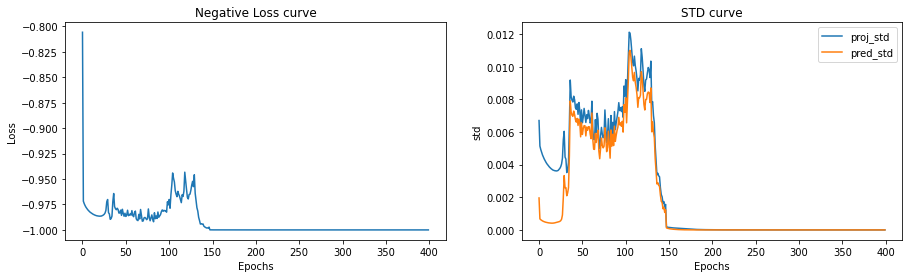

In [22]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Negative Loss curve")

plt.subplot(1,2,2)
plt.plot(history.history['proj_std'],label="proj_std")
plt.plot(history.history['pred_std'],label="pred_std")
plt.xlabel("Epochs")
plt.ylabel("std")
plt.title("STD curve") # range(0,1/sqrt(PROJECTION_DIM)) with 0 indicating a degenerate solution and vice versa
plt.legend()

In [23]:
backbone_path = f"backbone_{date}"
backbone.save(backbone_path)

2023-01-29 16:28:25.387394: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Performing downstream task to validate the model

In [24]:
# backbone = tf.keras.models.load_model("/kaggle/input/self-supervised-approach-to-image-classification/backbone_2023 01 25/")

In [25]:
backbone.trainable = False
def linear_model(num_classes):
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    x = backbone(inputs,training=False)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

model = linear_model(C.CLASSES)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
backbone (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
def preprocess(image,label,train=True):
#     image = tf.image.resize(image,C.SHAPE)
    if train:
#         image = tf.image.resize(image,C.SHAPE)
        image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
        image = tf.image.random_flip_left_right(image)
        image = tf.clip_by_value(image,0.,255.)
        return image,label
    elif not train:
        image = tf.image.resize(image,C.SHAPE)
        return image,label

In [27]:
train_ds = (
    train.map(partial(preprocess,train=True),num_parallel_calls=C.AUTO)
    .shuffle(C.BUFFER_SIZE)
    .batch(100)
    .prefetch(C.AUTO)
)

val_ds = (
    val.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .batch(100)
    .prefetch(C.AUTO)
)

x_test = (
    test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
    .map(lambda x,y: x)
    .batch(64)
)

# y_test = (
#     test.map(partial(preprocess,train=False),num_parallel_calls=C.AUTO)
#     .map(lambda x,y: y)
#     .batch(64)
# )

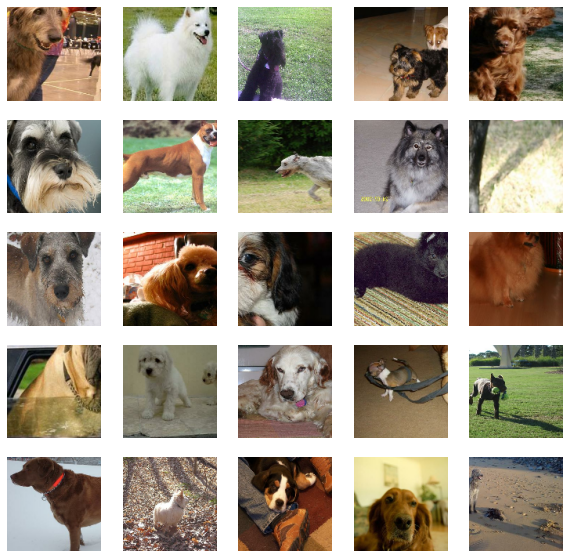

In [28]:
x,y = next(iter(train_ds))
visualize(x)

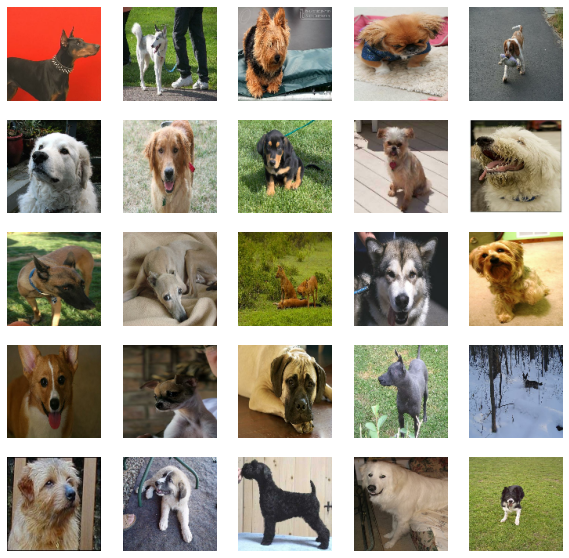

In [29]:
x,y = next(iter(val_ds))
visualize(x)

In [30]:
steps = 90 * tf.data.experimental.cardinality(train_ds) 
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 30.0,
    decay_steps = steps
)


opt = tf.keras.optimizers.SGD(
    learning_rate = schedule,
    momentum = 0.9
)

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = opt,
    metrics = ['accuracy']
)


hist = model.fit(
    train_ds,
    steps_per_epoch = train_ds.cardinality().numpy(),
    validation_data = val_ds,
    validation_steps = val_ds.cardinality().numpy(),
    epochs = 90,
    verbose = 1
)

Epoch 1/90
39/96 [===========>..................] - ETA: 7s - loss: 11147.0645 - accuracy: 0.2528

Cleanup called...


96/96 [==============================] - 20s 163ms/step - loss: 9059.6289 - accuracy: 0.3587 - val_loss: 7992.4375 - val_accuracy: 0.4150
Epoch 2/90
39/96 [===========>..................] - ETA: 7s - loss: 6186.1250 - accuracy: 0.5221

Cleanup called...


96/96 [==============================] - 18s 174ms/step - loss: 6251.2236 - accuracy: 0.5229 - val_loss: 8175.2134 - val_accuracy: 0.4475
Epoch 3/90
39/96 [===========>..................] - ETA: 7s - loss: 5709.2637 - accuracy: 0.5672

Cleanup called...


96/96 [==============================] - 16s 152ms/step - loss: 5890.1948 - accuracy: 0.5584 - val_loss: 8235.4736 - val_accuracy: 0.4679
Epoch 4/90
39/96 [===========>..................] - ETA: 9s - loss: 5785.8921 - accuracy: 0.5697

Cleanup called...


96/96 [==============================] - 18s 169ms/step - loss: 5802.5029 - accuracy: 0.5746 - val_loss: 9059.3613 - val_accuracy: 0.4654
Epoch 5/90
39/96 [===========>..................] - ETA: 8s - loss: 5668.9712 - accuracy: 0.5785

Cleanup called...


96/96 [==============================] - 17s 165ms/step - loss: 5468.4575 - accuracy: 0.5962 - val_loss: 8170.3867 - val_accuracy: 0.4850
Epoch 6/90
40/96 [===========>..................] - ETA: 7s - loss: 5097.7432 - accuracy: 0.6150

Cleanup called...


96/96 [==============================] - 16s 151ms/step - loss: 5044.8779 - accuracy: 0.6212 - val_loss: 8938.3799 - val_accuracy: 0.4717
Epoch 7/90
39/96 [===========>..................] - ETA: 9s - loss: 4862.1206 - accuracy: 0.6328

Cleanup called...


96/96 [==============================] - 18s 179ms/step - loss: 4809.4795 - accuracy: 0.6318 - val_loss: 8176.4375 - val_accuracy: 0.4879
Epoch 8/90
39/96 [===========>..................] - ETA: 7s - loss: 5032.4497 - accuracy: 0.6292

Cleanup called...


96/96 [==============================] - 17s 160ms/step - loss: 5049.5708 - accuracy: 0.6246 - val_loss: 9296.6680 - val_accuracy: 0.4787
Epoch 9/90
39/96 [===========>..................] - ETA: 9s - loss: 4983.9409 - accuracy: 0.6346

Cleanup called...


96/96 [==============================] - 18s 168ms/step - loss: 4925.3794 - accuracy: 0.6436 - val_loss: 9526.8467 - val_accuracy: 0.4750
Epoch 10/90
39/96 [===========>..................] - ETA: 8s - loss: 4939.5435 - accuracy: 0.6438

Cleanup called...


96/96 [==============================] - 17s 162ms/step - loss: 4606.9482 - accuracy: 0.6529 - val_loss: 9275.4883 - val_accuracy: 0.4812
Epoch 11/90
39/96 [===========>..................] - ETA: 8s - loss: 4778.9390 - accuracy: 0.6415

Cleanup called...


96/96 [==============================] - 18s 169ms/step - loss: 4641.5806 - accuracy: 0.6544 - val_loss: 9243.5811 - val_accuracy: 0.4900
Epoch 12/90
39/96 [===========>..................] - ETA: 7s - loss: 4469.0503 - accuracy: 0.6667

Cleanup called...


96/96 [==============================] - 16s 152ms/step - loss: 4505.7969 - accuracy: 0.6642 - val_loss: 8926.6465 - val_accuracy: 0.5042
Epoch 13/90
39/96 [===========>..................] - ETA: 7s - loss: 3963.7896 - accuracy: 0.6836

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 4127.8979 - accuracy: 0.6778 - val_loss: 8877.3066 - val_accuracy: 0.5054
Epoch 14/90
40/96 [===========>..................] - ETA: 8s - loss: 3933.3101 - accuracy: 0.6913

Cleanup called...


96/96 [==============================] - 18s 171ms/step - loss: 4076.6587 - accuracy: 0.6856 - val_loss: 9597.9697 - val_accuracy: 0.4821
Epoch 15/90
40/96 [===========>..................] - ETA: 8s - loss: 4291.2773 - accuracy: 0.6755

Cleanup called...


96/96 [==============================] - 17s 162ms/step - loss: 4176.5952 - accuracy: 0.6789 - val_loss: 9998.5010 - val_accuracy: 0.4983
Epoch 16/90
39/96 [===========>..................] - ETA: 7s - loss: 4378.3779 - accuracy: 0.6803

Cleanup called...


96/96 [==============================] - 18s 170ms/step - loss: 4127.0923 - accuracy: 0.6827 - val_loss: 9568.5635 - val_accuracy: 0.4971
Epoch 17/90
39/96 [===========>..................] - ETA: 7s - loss: 4044.9539 - accuracy: 0.6949

Cleanup called...


96/96 [==============================] - 16s 154ms/step - loss: 3859.7542 - accuracy: 0.7013 - val_loss: 9752.4980 - val_accuracy: 0.4929
Epoch 18/90
40/96 [===========>..................] - ETA: 9s - loss: 4033.8201 - accuracy: 0.6895 

Cleanup called...


96/96 [==============================] - 19s 179ms/step - loss: 3898.7725 - accuracy: 0.6965 - val_loss: 9272.4863 - val_accuracy: 0.5079
Epoch 19/90
39/96 [===========>..................] - ETA: 8s - loss: 3899.6477 - accuracy: 0.7028

Cleanup called...


96/96 [==============================] - 17s 159ms/step - loss: 3826.6584 - accuracy: 0.7090 - val_loss: 9314.5918 - val_accuracy: 0.5133
Epoch 20/90
40/96 [===========>..................] - ETA: 9s - loss: 3732.8984 - accuracy: 0.7038

Cleanup called...


96/96 [==============================] - 19s 169ms/step - loss: 3722.1104 - accuracy: 0.7083 - val_loss: 9443.0977 - val_accuracy: 0.5050
Epoch 21/90
39/96 [===========>..................] - ETA: 7s - loss: 3529.4856 - accuracy: 0.7097

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 3572.7109 - accuracy: 0.7141 - val_loss: 9289.3154 - val_accuracy: 0.5196
Epoch 22/90
39/96 [===========>..................] - ETA: 8s - loss: 3518.6162 - accuracy: 0.7215

Cleanup called...


96/96 [==============================] - 18s 159ms/step - loss: 3624.1729 - accuracy: 0.7135 - val_loss: 9761.5068 - val_accuracy: 0.5021
Epoch 23/90
39/96 [===========>..................] - ETA: 7s - loss: 3552.4089 - accuracy: 0.7100

Cleanup called...


96/96 [==============================] - 17s 159ms/step - loss: 3445.7900 - accuracy: 0.7159 - val_loss: 9116.2012 - val_accuracy: 0.5033
Epoch 24/90
39/96 [===========>..................] - ETA: 8s - loss: 3310.7808 - accuracy: 0.7244

Cleanup called...


96/96 [==============================] - 17s 155ms/step - loss: 3167.2180 - accuracy: 0.7319 - val_loss: 9277.3076 - val_accuracy: 0.5238
Epoch 25/90
39/96 [===========>..................] - ETA: 8s - loss: 3343.6401 - accuracy: 0.7208

Cleanup called...


96/96 [==============================] - 17s 163ms/step - loss: 3250.5876 - accuracy: 0.7296 - val_loss: 9248.8994 - val_accuracy: 0.5038
Epoch 26/90
39/96 [===========>..................] - ETA: 7s - loss: 3397.5112 - accuracy: 0.7228

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 3363.8547 - accuracy: 0.7225 - val_loss: 8906.7070 - val_accuracy: 0.5150
Epoch 27/90
39/96 [===========>..................] - ETA: 7s - loss: 3073.9529 - accuracy: 0.7400

Cleanup called...


96/96 [==============================] - 18s 170ms/step - loss: 3006.2336 - accuracy: 0.7404 - val_loss: 9118.1035 - val_accuracy: 0.5167
Epoch 28/90
39/96 [===========>..................] - ETA: 7s - loss: 3094.5427 - accuracy: 0.7362

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 3133.5962 - accuracy: 0.7334 - val_loss: 9096.7471 - val_accuracy: 0.5204
Epoch 29/90
39/96 [===========>..................] - ETA: 9s - loss: 2921.5579 - accuracy: 0.7418

Cleanup called...


96/96 [==============================] - 18s 168ms/step - loss: 2986.9221 - accuracy: 0.7452 - val_loss: 9343.6436 - val_accuracy: 0.5079
Epoch 30/90
39/96 [===========>..................] - ETA: 8s - loss: 3013.6729 - accuracy: 0.7392

Cleanup called...


96/96 [==============================] - 17s 163ms/step - loss: 2945.8577 - accuracy: 0.7491 - val_loss: 9114.0625 - val_accuracy: 0.5079
Epoch 31/90
38/96 [==========>...................] - ETA: 10s - loss: 2992.1592 - accuracy: 0.7411

Cleanup called...


96/96 [==============================] - 18s 178ms/step - loss: 2970.0913 - accuracy: 0.7457 - val_loss: 9091.4180 - val_accuracy: 0.5171
Epoch 32/90
40/96 [===========>..................] - ETA: 7s - loss: 2615.4214 - accuracy: 0.7617

Cleanup called...


96/96 [==============================] - 16s 154ms/step - loss: 2653.8311 - accuracy: 0.7630 - val_loss: 9252.0137 - val_accuracy: 0.5104
Epoch 33/90
39/96 [===========>..................] - ETA: 9s - loss: 2596.4541 - accuracy: 0.7549

Cleanup called...


96/96 [==============================] - 18s 174ms/step - loss: 2637.4929 - accuracy: 0.7578 - val_loss: 8803.8379 - val_accuracy: 0.5279
Epoch 34/90
40/96 [===========>..................] - ETA: 7s - loss: 2682.4663 - accuracy: 0.7642

Cleanup called...


96/96 [==============================] - 16s 154ms/step - loss: 2557.1555 - accuracy: 0.7682 - val_loss: 8592.4346 - val_accuracy: 0.5304
Epoch 35/90
39/96 [===========>..................] - ETA: 10s - loss: 2601.4182 - accuracy: 0.7564

Cleanup called...


96/96 [==============================] - 19s 181ms/step - loss: 2545.7390 - accuracy: 0.7608 - val_loss: 8751.8008 - val_accuracy: 0.5204
Epoch 36/90
40/96 [===========>..................] - ETA: 7s - loss: 2659.5728 - accuracy: 0.7540

Cleanup called...


96/96 [==============================] - 16s 153ms/step - loss: 2632.5562 - accuracy: 0.7614 - val_loss: 9261.3896 - val_accuracy: 0.4988
Epoch 37/90
39/96 [===========>..................] - ETA: 10s - loss: 2562.8635 - accuracy: 0.7631

Cleanup called...


96/96 [==============================] - 18s 170ms/step - loss: 2512.4368 - accuracy: 0.7686 - val_loss: 8532.8887 - val_accuracy: 0.5321
Epoch 38/90
39/96 [===========>..................] - ETA: 7s - loss: 2523.6531 - accuracy: 0.7651

Cleanup called...


96/96 [==============================] - 16s 152ms/step - loss: 2367.9133 - accuracy: 0.7755 - val_loss: 8210.1250 - val_accuracy: 0.5275
Epoch 39/90
40/96 [===========>..................] - ETA: 9s - loss: 2364.7710 - accuracy: 0.7853

Cleanup called...


96/96 [==============================] - 18s 169ms/step - loss: 2351.1335 - accuracy: 0.7759 - val_loss: 8470.6963 - val_accuracy: 0.5346
Epoch 40/90
39/96 [===========>..................] - ETA: 8s - loss: 2246.7786 - accuracy: 0.7810

Cleanup called...


96/96 [==============================] - 16s 154ms/step - loss: 2280.4224 - accuracy: 0.7821 - val_loss: 8317.3779 - val_accuracy: 0.5308
Epoch 41/90
39/96 [===========>..................] - ETA: 9s - loss: 2133.8501 - accuracy: 0.7856

Cleanup called...


96/96 [==============================] - 18s 165ms/step - loss: 2241.7563 - accuracy: 0.7796 - val_loss: 8455.4219 - val_accuracy: 0.5242
Epoch 42/90
39/96 [===========>..................] - ETA: 7s - loss: 2257.6819 - accuracy: 0.7823

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 2201.8716 - accuracy: 0.7854 - val_loss: 8573.0879 - val_accuracy: 0.5113
Epoch 43/90
40/96 [===========>..................] - ETA: 7s - loss: 2219.3835 - accuracy: 0.7800

Cleanup called...


96/96 [==============================] - 16s 156ms/step - loss: 2101.9641 - accuracy: 0.7875 - val_loss: 7978.1050 - val_accuracy: 0.5350
Epoch 44/90
39/96 [===========>..................] - ETA: 8s - loss: 2281.6721 - accuracy: 0.7695

Cleanup called...


96/96 [==============================] - 18s 174ms/step - loss: 2157.4666 - accuracy: 0.7775 - val_loss: 8244.0996 - val_accuracy: 0.5179
Epoch 45/90
40/96 [===========>..................] - ETA: 7s - loss: 2003.2555 - accuracy: 0.7940

Cleanup called...


96/96 [==============================] - 16s 153ms/step - loss: 2022.0938 - accuracy: 0.7929 - val_loss: 8229.7080 - val_accuracy: 0.5217
Epoch 46/90
39/96 [===========>..................] - ETA: 8s - loss: 1941.0044 - accuracy: 0.7974

Cleanup called...


96/96 [==============================] - 19s 173ms/step - loss: 1959.0529 - accuracy: 0.7957 - val_loss: 7863.4561 - val_accuracy: 0.5296
Epoch 47/90
40/96 [===========>..................] - ETA: 7s - loss: 2006.7380 - accuracy: 0.7937

Cleanup called...


96/96 [==============================] - 16s 158ms/step - loss: 1922.2169 - accuracy: 0.8004 - val_loss: 7699.9673 - val_accuracy: 0.5217
Epoch 48/90
39/96 [===========>..................] - ETA: 8s - loss: 1980.5377 - accuracy: 0.7944

Cleanup called...


96/96 [==============================] - 18s 172ms/step - loss: 1959.5900 - accuracy: 0.7982 - val_loss: 7989.6748 - val_accuracy: 0.5229
Epoch 49/90
39/96 [===========>..................] - ETA: 8s - loss: 1864.0378 - accuracy: 0.7982

Cleanup called...


96/96 [==============================] - 17s 164ms/step - loss: 1784.4044 - accuracy: 0.7999 - val_loss: 7778.9492 - val_accuracy: 0.5408
Epoch 50/90
40/96 [===========>..................] - ETA: 10s - loss: 1691.2238 - accuracy: 0.8062

Cleanup called...


96/96 [==============================] - 18s 173ms/step - loss: 1724.7858 - accuracy: 0.8064 - val_loss: 7297.6626 - val_accuracy: 0.5496
Epoch 51/90
39/96 [===========>..................] - ETA: 7s - loss: 1644.1593 - accuracy: 0.8146

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 1758.8998 - accuracy: 0.8072 - val_loss: 7771.2949 - val_accuracy: 0.5346
Epoch 52/90
39/96 [===========>..................] - ETA: 9s - loss: 1773.2374 - accuracy: 0.8005

Cleanup called...


96/96 [==============================] - 18s 166ms/step - loss: 1651.9741 - accuracy: 0.8116 - val_loss: 7670.1768 - val_accuracy: 0.5354
Epoch 53/90
40/96 [===========>..................] - ETA: 7s - loss: 1578.4432 - accuracy: 0.8142

Cleanup called...


96/96 [==============================] - 16s 151ms/step - loss: 1588.9541 - accuracy: 0.8183 - val_loss: 7475.4775 - val_accuracy: 0.5354
Epoch 54/90
40/96 [===========>..................] - ETA: 8s - loss: 1493.4489 - accuracy: 0.8200

Cleanup called...


96/96 [==============================] - 19s 166ms/step - loss: 1548.5159 - accuracy: 0.8171 - val_loss: 7298.7310 - val_accuracy: 0.5462
Epoch 55/90
40/96 [===========>..................] - ETA: 7s - loss: 1516.9525 - accuracy: 0.8227

Cleanup called...


96/96 [==============================] - 16s 158ms/step - loss: 1524.0072 - accuracy: 0.8245 - val_loss: 7390.6426 - val_accuracy: 0.5350
Epoch 56/90
40/96 [===========>..................] - ETA: 9s - loss: 1484.7222 - accuracy: 0.8155

Cleanup called...


96/96 [==============================] - 18s 168ms/step - loss: 1491.2915 - accuracy: 0.8186 - val_loss: 7280.5552 - val_accuracy: 0.5367
Epoch 57/90
39/96 [===========>..................] - ETA: 7s - loss: 1497.8418 - accuracy: 0.8238

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 1468.7458 - accuracy: 0.8269 - val_loss: 7128.7632 - val_accuracy: 0.5408
Epoch 58/90
39/96 [===========>..................] - ETA: 7s - loss: 1462.5027 - accuracy: 0.8221

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 1453.9495 - accuracy: 0.8197 - val_loss: 7177.3394 - val_accuracy: 0.5421
Epoch 59/90
40/96 [===========>..................] - ETA: 8s - loss: 1441.2406 - accuracy: 0.8310

Cleanup called...


96/96 [==============================] - 18s 174ms/step - loss: 1403.2529 - accuracy: 0.8333 - val_loss: 6748.5527 - val_accuracy: 0.5500
Epoch 60/90
39/96 [===========>..................] - ETA: 7s - loss: 1434.5881 - accuracy: 0.8277

Cleanup called...


96/96 [==============================] - 17s 160ms/step - loss: 1401.1392 - accuracy: 0.8286 - val_loss: 6699.0845 - val_accuracy: 0.5471
Epoch 61/90
39/96 [===========>..................] - ETA: 8s - loss: 1432.0995 - accuracy: 0.8221

Cleanup called...


96/96 [==============================] - 18s 177ms/step - loss: 1426.8441 - accuracy: 0.8304 - val_loss: 6948.3413 - val_accuracy: 0.5433
Epoch 62/90
39/96 [===========>..................] - ETA: 8s - loss: 1327.3636 - accuracy: 0.8318

Cleanup called...


96/96 [==============================] - 17s 159ms/step - loss: 1244.6757 - accuracy: 0.8358 - val_loss: 6850.1187 - val_accuracy: 0.5475
Epoch 63/90
40/96 [===========>..................] - ETA: 7s - loss: 1368.3584 - accuracy: 0.8332

Cleanup called...


96/96 [==============================] - 18s 171ms/step - loss: 1363.5085 - accuracy: 0.8311 - val_loss: 6838.6890 - val_accuracy: 0.5521
Epoch 64/90
39/96 [===========>..................] - ETA: 8s - loss: 1243.1650 - accuracy: 0.8423

Cleanup called...


96/96 [==============================] - 17s 162ms/step - loss: 1280.3190 - accuracy: 0.8380 - val_loss: 6708.3232 - val_accuracy: 0.5512
Epoch 65/90
39/96 [===========>..................] - ETA: 7s - loss: 1203.1759 - accuracy: 0.8464

Cleanup called...


96/96 [==============================] - 18s 173ms/step - loss: 1166.5703 - accuracy: 0.8485 - val_loss: 6716.5508 - val_accuracy: 0.5462
Epoch 66/90
40/96 [===========>..................] - ETA: 8s - loss: 1267.4122 - accuracy: 0.8330

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 1175.0786 - accuracy: 0.8431 - val_loss: 6630.3594 - val_accuracy: 0.5458
Epoch 67/90
39/96 [===========>..................] - ETA: 9s - loss: 1251.7760 - accuracy: 0.8341

Cleanup called...


96/96 [==============================] - 18s 178ms/step - loss: 1246.5615 - accuracy: 0.8367 - val_loss: 6621.7144 - val_accuracy: 0.5450
Epoch 68/90
39/96 [===========>..................] - ETA: 8s - loss: 1153.8706 - accuracy: 0.8467

Cleanup called...


96/96 [==============================] - 16s 157ms/step - loss: 1152.5352 - accuracy: 0.8431 - val_loss: 6694.0371 - val_accuracy: 0.5437
Epoch 69/90
39/96 [===========>..................] - ETA: 9s - loss: 1089.3243 - accuracy: 0.8454 

Cleanup called...


96/96 [==============================] - 18s 176ms/step - loss: 1104.2643 - accuracy: 0.8522 - val_loss: 6529.6411 - val_accuracy: 0.5525
Epoch 70/90
40/96 [===========>..................] - ETA: 7s - loss: 1158.5928 - accuracy: 0.8457

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 1147.9055 - accuracy: 0.8501 - val_loss: 6609.8794 - val_accuracy: 0.5412
Epoch 71/90
39/96 [===========>..................] - ETA: 9s - loss: 1161.2770 - accuracy: 0.8428

Cleanup called...


96/96 [==============================] - 18s 165ms/step - loss: 1137.8842 - accuracy: 0.8482 - val_loss: 6414.8257 - val_accuracy: 0.5487
Epoch 72/90
39/96 [===========>..................] - ETA: 7s - loss: 976.7885 - accuracy: 0.8536

Cleanup called...


96/96 [==============================] - 17s 159ms/step - loss: 1045.6179 - accuracy: 0.8527 - val_loss: 6357.7051 - val_accuracy: 0.5587
Epoch 73/90
39/96 [===========>..................] - ETA: 7s - loss: 1055.3708 - accuracy: 0.8492

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 1122.4583 - accuracy: 0.8468 - val_loss: 6402.2905 - val_accuracy: 0.5567
Epoch 74/90
40/96 [===========>..................] - ETA: 8s - loss: 1009.7473 - accuracy: 0.8675

Cleanup called...


96/96 [==============================] - 18s 178ms/step - loss: 1040.2690 - accuracy: 0.8570 - val_loss: 6368.7695 - val_accuracy: 0.5608
Epoch 75/90
39/96 [===========>..................] - ETA: 8s - loss: 1024.1537 - accuracy: 0.8572

Cleanup called...


96/96 [==============================] - 17s 165ms/step - loss: 1082.6646 - accuracy: 0.8543 - val_loss: 6350.3120 - val_accuracy: 0.5537
Epoch 76/90
39/96 [===========>..................] - ETA: 8s - loss: 1006.8700 - accuracy: 0.8651

Cleanup called...


96/96 [==============================] - 18s 176ms/step - loss: 1017.8074 - accuracy: 0.8626 - val_loss: 6334.4673 - val_accuracy: 0.5521
Epoch 77/90
39/96 [===========>..................] - ETA: 9s - loss: 904.7141 - accuracy: 0.8546

Cleanup called...


96/96 [==============================] - 17s 162ms/step - loss: 969.8569 - accuracy: 0.8591 - val_loss: 6268.1074 - val_accuracy: 0.5462
Epoch 78/90
39/96 [===========>..................] - ETA: 9s - loss: 963.1679 - accuracy: 0.8567 

Cleanup called...


96/96 [==============================] - 18s 173ms/step - loss: 1020.3588 - accuracy: 0.8544 - val_loss: 6222.5830 - val_accuracy: 0.5546
Epoch 79/90
40/96 [===========>..................] - ETA: 7s - loss: 926.0023 - accuracy: 0.8630

Cleanup called...


96/96 [==============================] - 17s 152ms/step - loss: 978.8784 - accuracy: 0.8615 - val_loss: 6228.9844 - val_accuracy: 0.5575
Epoch 80/90
40/96 [===========>..................] - ETA: 8s - loss: 1030.0780 - accuracy: 0.8457

Cleanup called...


96/96 [==============================] - 18s 171ms/step - loss: 994.3229 - accuracy: 0.8537 - val_loss: 6230.0215 - val_accuracy: 0.5500
Epoch 81/90
39/96 [===========>..................] - ETA: 7s - loss: 996.5663 - accuracy: 0.8587 

Cleanup called...


96/96 [==============================] - 16s 153ms/step - loss: 1011.2747 - accuracy: 0.8573 - val_loss: 6234.1523 - val_accuracy: 0.5508
Epoch 82/90
39/96 [===========>..................] - ETA: 10s - loss: 976.3176 - accuracy: 0.8569

Cleanup called...


96/96 [==============================] - 18s 171ms/step - loss: 939.6577 - accuracy: 0.8610 - val_loss: 6197.6309 - val_accuracy: 0.5529
Epoch 83/90
40/96 [===========>..................] - ETA: 7s - loss: 944.7397 - accuracy: 0.8600

Cleanup called...


96/96 [==============================] - 16s 155ms/step - loss: 946.0151 - accuracy: 0.8601 - val_loss: 6198.2168 - val_accuracy: 0.5558
Epoch 84/90
39/96 [===========>..................] - ETA: 8s - loss: 997.3561 - accuracy: 0.8662

Cleanup called...


96/96 [==============================] - 18s 165ms/step - loss: 993.5600 - accuracy: 0.8629 - val_loss: 6202.5503 - val_accuracy: 0.5571
Epoch 85/90
39/96 [===========>..................] - ETA: 7s - loss: 1019.1418 - accuracy: 0.8638

Cleanup called...


96/96 [==============================] - 16s 156ms/step - loss: 960.8381 - accuracy: 0.8654 - val_loss: 6184.1807 - val_accuracy: 0.5571
Epoch 86/90
40/96 [===========>..................] - ETA: 10s - loss: 918.5034 - accuracy: 0.8700

Cleanup called...


96/96 [==============================] - 18s 176ms/step - loss: 943.6098 - accuracy: 0.8647 - val_loss: 6180.8540 - val_accuracy: 0.5583
Epoch 87/90
39/96 [===========>..................] - ETA: 7s - loss: 972.8787 - accuracy: 0.8597

Cleanup called...


96/96 [==============================] - 17s 159ms/step - loss: 980.4860 - accuracy: 0.8608 - val_loss: 6180.1221 - val_accuracy: 0.5583
Epoch 88/90
39/96 [===========>..................] - ETA: 8s - loss: 918.5951 - accuracy: 0.8562

Cleanup called...


96/96 [==============================] - 17s 161ms/step - loss: 925.7964 - accuracy: 0.8600 - val_loss: 6180.2925 - val_accuracy: 0.5575
Epoch 89/90
39/96 [===========>..................] - ETA: 9s - loss: 1012.9182 - accuracy: 0.8587

Cleanup called...


96/96 [==============================] - 17s 164ms/step - loss: 982.0318 - accuracy: 0.8607 - val_loss: 6180.4575 - val_accuracy: 0.5575
Epoch 90/90
39/96 [===========>..................] - ETA: 9s - loss: 898.8614 - accuracy: 0.8669

Cleanup called...


96/96 [==============================] - 18s 169ms/step - loss: 922.7587 - accuracy: 0.8670 - val_loss: 6180.3950 - val_accuracy: 0.5575


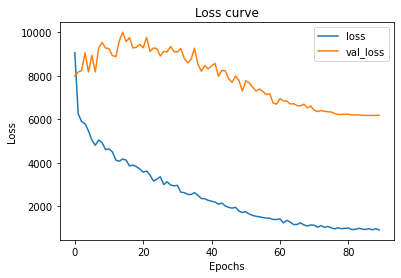

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend(['loss','val_loss'])

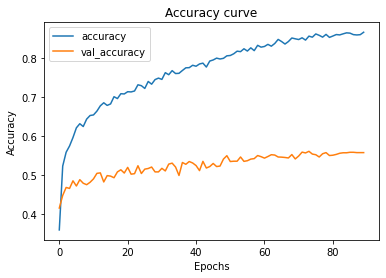

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curve")
plt.legend(["accuracy","val_accuracy"])

In [33]:
y_pred = np.argmax(model.predict(x_test),axis=1)

In [34]:
y = []
for _,b in test.as_numpy_iterator():
    y.append(b)

In [35]:
print(accuracy_score(y,y_pred))

0.5613053613053613
